In [1]:
import sys
sys.path.insert(0, '../python_scripts')
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#metadata = utils.load("./variables/metadata.p")
from keras.optimizers import *
from keras.layers import *
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.preprocessing.image import Iterator
from keras.models import Model
from keras.applications.resnet50 import ResNet50

remote = callbacks.RemoteMonitor(root='http://localhost:9000')
from keras.models import load_model
import time
import heatmap
from meta import *
from h_gen import *
from utils import *
import gc

Using Theano backend.


DEBUG: nvcc STDOUT

nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
mod.cu
   Creating library C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpxqo2biee/m91973e5c136ea49268a916ff971b7377.lib and object C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpxqo2biee/m91973e5c136ea49268a916ff971b7377.exp


Using gpu device 0: GeForce GTX 1070 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)

C:\Program Files\Anaconda3\lib\site-packages\theano\sandbox\cuda\__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
image_size = [(768, 1216),(1344,2240)]
FOLDER_TRAIN = "./temp_training/resnet/"

In [3]:
SPLIT = 0.8 # For the train/test split
metadata = meta.create_metadata()

['../JSONS/alb_labels.json', '../JSONS/bet_labels.json', '../JSONS/dol_labels.json', '../JSONS/lag_labels.json', '../JSONS/other_labels.json', '../JSONS/shark_labels.json', '../JSONS/yft_labels.json']



In [4]:
for img_size in image_size:
    dim = str(img_size[0])+'_'+str(img_size[1])+'/'
    mk(FOLDER_TRAIN+''+dim)

## First step, create train and test set.

In [5]:
import operator
output_size = []
nb_filters = []
mask_size = []
def find_bigger(mask):
    obj = []
    for i,m in enumerate(mask):
        obj.append([i,m[0]*m[1]])
    return sorted(obj,key=operator.itemgetter(1),reverse=True)[0][0]
    
for i,img_size in enumerate(image_size):
    dim = str(img_size[0])+'_'+str(img_size[1])+'/'
    output_size.append(utils.load(FOLDER_TRAIN +dim+ "mask_size"))
    nb_filters.append(output_size[0][0])
    mask_size.append(output_size[i][1:])
    print("size of our filters: " + str(nb_filters[i]))
    print("size of our mask: " + str(mask_size[i]))
nb_filters = nb_filters[0]
print(mask_size)
print(nb_filters)

size of our filters: 2048
size of our mask: (18, 32)
size of our filters: 2048
size of our mask: (36, 64)
[(18, 32), (36, 64)]
2048


In [6]:
##THAT PART IS ONLY FOR ME . AS I HAVE ONLY 127 IMAGES IN (1152, 2048)
def filter_sample_to_same(list_files):
    import collections
    collection = collections.defaultdict(list)
    for list_file in list_files:
        for f in list_file:
            collection[f.split('/')[-1].split('.')[0]].append(f)
    return collection
def filter_collection(collection):
    obj = []
    for key in collection.keys():
        if len(collection[key]) >1:
            obj.append(collection[key])
    return obj
        
def get_same_sample():
    list_files = []
    for img_size in image_size:    
        dim = str(img_size[0])+'_'+str(img_size[1])+'/'
        list_files.append(h_gen.get_all_images(regex=FOLDER_TRAIN +dim+ "*.npy"))
    return list_files
collection = filter_collection(filter_sample_to_same(get_same_sample()))
print(len(collection))

3777


In [7]:
list_files = []
list_files = [x[0].split('/')[-1].split('.')[0]+'.jpg'  for x in collection]
random.shuffle(list_files)
l = int(0.8 * len(list_files))

training_set = list_files[:l]
test_set = list_files[l:]
print("First element for debug: " + training_set[0])

First element for debug: img_04702.jpg


## Second step, create the data generator.

In [8]:
import importlib
importlib.reload(h_gen)

<module 'h_gen' from '../python_scripts\\h_gen.py'>

In [8]:
class DiskArrayIterator(Iterator):
    
    def __init__(self, batch_size, nb_filters, mask_size, folder, file_list, 
                 metadata,image_size, with_name = False, shuffle=False, seed=None,debug2=False):
        self.batch_size=batch_size
        self.nb_filters=nb_filters
        self.mask_size=mask_size
        self.folder=folder
        self.file_list=file_list
        self.metadata = metadata
        self.with_name = with_name
        self.image_size = image_size
        self.debug2 = debug2        
        super(DiskArrayIterator, self).__init__(len(file_list), batch_size, shuffle, seed)
    
    def find_bigger(mask):
        obj = []
        for i,m in enumerate(mask):
            obj.append([i,m[0]*m[1]])
        return sorted(obj,key=operator.itemgetter(1),reverse=True)[0][0]

    def next(self):
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        
        mask_larger = self.mask_size[find_bigger(self.mask_size)]
        reshaped = mask_larger[0]*mask_larger[1]
        X = [np.zeros((self.batch_size, self.nb_filters) + m) for m in self.mask_size]
        Y = [np.zeros((self.batch_size, reshaped,1)) for _ in range(5)]
        W = [np.zeros((self.batch_size, reshaped))   for _ in range(5)]
        selected_files = [self.file_list[i] for i in index_array]
        meta = [metadata[x] for x in selected_files]
        # We loop over the files
        is_rects = []
        for c, v in enumerate(meta):
            if not self.debug2:
                masks, m_weights = h_gen.get_5_masks_w(v, mask_larger)
            if self.debug2:
                masks, m_weights,is_rect = h_gen.get_5_masks_w(v, mask_larger,debug_bool=self.debug2)
                is_rects.append(is_rect)
            
            # loop over the 5 masks
            for i, mask in enumerate(masks):
                
                mask0 = np.expand_dims(mask, axis=0)
                mask0 = np.reshape(mask0,(reshaped,))
                y = np.expand_dims(mask0, axis=1)
                for j,image_size in enumerate(self.image_size):
                    dim = str(image_size[0])+'_'+str(image_size[1])+'/'
                    X[j][c] = utils.load_array(self.folder +dim+v["filename"])
                m_weight = np.expand_dims(m_weights[i], axis=0)
                m_weight = np.reshape(m_weight,(reshaped,))
                Y[i][c] = y
                W[i][c] = m_weight
        
        if self.debug2:
            return X, Y, W, [v["path"] for v in meta],is_rects
        if self.with_name:
            return X, Y, W, [v["path"] for v in meta]
        return X, Y, W
        #return X, Y

In [9]:
import importlib
importlib.reload(h_gen)

<module 'h_gen' from '../python_scripts\\h_gen.py'>

In [10]:
for X, Y, W , paths,is_rects in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size, with_name=True, seed=int(np.random.uniform(1,100)),shuffle=True,debug2=True):
    break

In [11]:
print("shape of X:", [x.shape for x in X])
print("lenght of Y:", len(Y))
print("shape of Y[0]:", Y[0].shape)
print("lenght of W:", len(W))
print("shape of W[0]:", W[0].shape)
print(is_rects)

shape of X: [(16, 2048, 18, 32), (16, 2048, 36, 64)]
lenght of Y: 5
shape of Y[0]: (16, 2304, 1)
lenght of W: 5
shape of W[0]: (16, 2304)
[True, True, True, True, True, False, True, True, True, True, True, True, True, False, False, False]


In [12]:
"""for i in range(4):
    print(paths[i])
    plt.imshow(load_img(paths[i]))
    plt.show()
    for j in range(5):
        plt.figure(figsize=(24,24))
        plt.subplot(1,2,1)
        plt.imshow(np.reshape(Y[j][i],mask_size[1]))
        plt.subplot(1,2,2)
        plt.imshow(np.reshape(W[j][i],mask_size[1]))        
        plt.show()"""

'for i in range(4):\n    print(paths[i])\n    plt.imshow(load_img(paths[i]))\n    plt.show()\n    for j in range(5):\n        plt.figure(figsize=(24,24))\n        plt.subplot(1,2,1)\n        plt.imshow(np.reshape(Y[j][i],mask_size[1]))\n        plt.subplot(1,2,2)\n        plt.imshow(np.reshape(W[j][i],mask_size[1]))        \n        plt.show()'

In [ ]:
train_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size)
test_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size)

## Third step, create the network.

##### First, let's create the network that will be shared:

In [14]:
nb_input_filters = 1000
print(mask_size)
print(nb_filters)
# We put this value so that we can reuse the weights of the final layer of the resnet.

[(18, 32), (36, 64)]
2048


In [108]:
def model_custom_1(nb_input_filters):
    img_input = Input(shape=(nb_input_filters,) + (None,None)) 
    x = Convolution2D(512, 1, 1, activation='relu')(img_input)
    #x = BatchNormalization(axis=1)(x)
    x = Convolution2D(256, 1, 1, activation='relu')(x)
    #x = BatchNormalization(axis=1)(x)
    x = Convolution2D(128, 1, 1, activation='relu')(x)
    #x = BatchNormalization(axis=1)(x)
    last_filter = 64
    x = Convolution2D(last_filter, 1, 1, activation='relu')(x)
    return Model(input=img_input,output=x), last_filter

def model_custom_2(nb_input_filters,m):
    a = Input(shape=(nb_input_filters,) + m)

    c = Convolution2D(128, 1, 1, activation='relu')(a)
    #c = BatchNormalization(axis=1)(c)
    c = Convolution2D(128, 1, 1, activation='relu')(c)
    #c = BatchNormalization(axis=1)(c)
    #d = BatchNormalization(axis=1)(d)
    return Model(input=a,output=c)

def final(shape=(256,36,64)):
    a = Input(shape=shape)

    c = Convolution2D(128, 1, 1, activation='relu')(a)
    c = Convolution2D(128, 1, 1, activation='relu')(c)
    #c = BatchNormalization(axis=1)(c)
    c = Convolution2D(8, 1, 1, activation='relu')(c)
    #c = BatchNormalization(axis=1)(c)
    #d = BatchNormalization(axis=1)(d)
    return Model(input=a,output=c)

##### Here is the final network:

In [143]:
def return_model(pool_branches = [(2,2), (4,4), (5,5), (8,8),(10,10)]):
    nb_input_filters = 1000
    N = 35
    img_inputs = [Input(shape=(nb_filters,) + m) for m in mask_size]

    first_con = Convolution2D(nb_input_filters, 1, 1, activation='relu')
    x, y = [first_con(inp) for inp in img_inputs]

    x = BatchNormalization(axis=1)(x)
    y = BatchNormalization(axis=1)(y)

    model_cus_1, last_filter = model_custom_1(nb_input_filters)
    x = model_cus_1(x)
    y = model_cus_1(y)

    x = model_custom_2(last_filter,mask_size[0])(x)
    y = model_custom_2(last_filter,mask_size[1])(y)

    x = UpSampling2D(size=(2, 2))(x)

    merge_out = Merge(mode='concat', concat_axis=1)([x,y])

    W = []
    f = final()
    for i in range(N):
        if i == 0:
            w = f(merge_out)
            w = heatmap.Softmax4D(axis=1)(w)
            w = Reshape((8, mask_size[1][0]*mask_size[1][1]))(w)
            w = Permute((2, 1))(w)
            W.append(w)
        else:
            if (i+2,i+2) in pool_branches:
                w = MaxPooling2D(pool_size=(i+2,i+2), strides=(1,1))(merge_out)
                w = f(w)
                w = heatmap.Softmax4D(axis=1)(w)
                w = Reshape((8, int(mask_size[1][0]-(i+1))*int(mask_size[1][1]-(i+1))))(w)
                w = Permute((2, 1))(w)
                W.append(w)

    model = Model(input=img_inputs, output=W)
    resnet = ResNet50()
    heatmap.insert_weights(resnet.layers[-1], model.layers[2])
    model.layers[2].trainable = False
    return model

In [144]:
model = return_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_394 (InputLayer)           (None, 2048, 18, 32)  0                                            
____________________________________________________________________________________________________
input_395 (InputLayer)           (None, 2048, 36, 64)  0                                            
____________________________________________________________________________________________________
convolution2d_721 (Convolution2D multiple              2049000     input_394[0][0]                  
                                                                   input_395[0][0]                  
____________________________________________________________________________________________________
batchnormalization_137 (BatchNor (None, 1000, 18, 32)  4000        convolution2d_721[0][0] 

In [121]:
model.output

[InplaceDimShuffle{0,2,1}.0,
 InplaceDimShuffle{0,2,1}.0,
 InplaceDimShuffle{0,2,1}.0,
 InplaceDimShuffle{0,2,1}.0,
 InplaceDimShuffle{0,2,1}.0]

##### Let's insert the imageNet weights:

In [ ]:
# We need the last weights of the resnet50:
resnet = ResNet50()

In [ ]:
model.layers[2]

In [ ]:
resnet.layers[-1]

In [ ]:
heatmap.insert_weights(resnet.layers[-1], model.layers[2])

In [ ]:
model_file = "models/resnet_mask_training.h5"
mk('models/')

In [ ]:
# we can now save the model.
model.save(model_file)

## Fourth step, training.

In [ ]:
del resnet
gc.collect()

In [ ]:
model_file = "models/resnet_mask_training.h5"
model = load_model(model_file)

In [ ]:
#model.summary()

In [ ]:
model.layers[2].trainable=False

In [ ]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.0, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=adam, sample_weight_mode="temporal")

In [ ]:
train_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size)
test_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size)
history = model.fit_generator(train_gen, samples_per_epoch=2, nb_epoch=150, callbacks=[remote], 
                              verbose=0,validation_data=test_gen, nb_val_samples=2)
#

In [ ]:
model.layers[2].trainable=True

In [ ]:
sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.0, nesterov=True)
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [ ]:
train_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size)
test_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size)
history = model.fit_generator(train_gen, samples_per_epoch=2, nb_epoch=25, callbacks=[remote], 
                              verbose=0,validation_data=test_gen, nb_val_samples=2)
#

In [11]:
file_trained = "models/fish_detection_trained_1.1.h5"

In [ ]:
model.save(file_trained)

In [12]:
model = load_model(file_trained)

## Fifth step, display results.

In [10]:
import sys
sys.path.insert(0, '../python_scripts')
import h_gen
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
import matplotlib.patches as patches
import numpy as np
import utils
import importlib
import threading
import meta
import heatmap
import itertools
import heatmap
import time
from numpy import unravel_index
import heatmaps_to_rect as htr
importlib.reload(htr)
importlib.reload(utils)
importlib.reload(meta)
importlib.reload(h_gen)

<module 'h_gen' from '../python_scripts\\h_gen.py'>

<h1> STATISCAL ANALYSIS OF MEAN_MAX RESULTS </h1>

In [14]:
Final = []
c = tq(total=100*16)
N = 100
n = 0
for X, Y, W , paths,is_rects in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size, with_name=True, shuffle=False,debug2=True):
    Z = model.predict(X)   
    n +=1
    if n < N:
        for i in range(16):
            c.update()
            maxs = []
            for j in range(5):
                maxs.append(np.max(Z[j][i]))
            mean_max = np.array(maxs).mean()
            try:
                Final.append([mean_max,is_rects[i]])
            except:
                pass
    else:
        break
import pickle        
pickle.dump( Final, open( "Final.p", "wb" ) )

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [10]:
Final = pickle.load( open( "Final.p", "rb" ) )

In [12]:
w_f = []
wo_f = []
for i in range(len(Final)):
    if Final[i][1]:
        w_f.append(Final[i][0])
    else:
        wo_f.append(Final[i][0])
w_f = np.array(w_f) 
wo_f = np.array(wo_f) 
print('LENGTH OF TEST : '+str(len(Final)))
print('mean w_f : '+str(np.array(w_f).mean()))
print('mean wo_f : '+str(np.array(wo_f).mean()))
print('min w_f : '+str(np.array(w_f).min()))
print('min wo_f : '+str(np.array(wo_f).min()))
print('std w_f : '+str(np.array(w_f).std()))
print('std wo_f : '+str(np.array(wo_f).std()))
print('THRESHOLD : '+str(np.array(w_f).mean() - np.array(w_f).std()))

LENGTH OF TEST : 1560
mean w_f : 0.648588
mean wo_f : 0.246224
min w_f : 0.0959474
min wo_f : 0.059991
std w_f : 0.271008
std wo_f : 0.129603
THRESHOLD : 0.377581


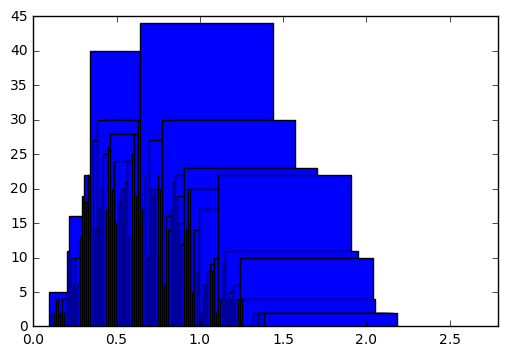

In [13]:
w_f = np.array(w_f)
wo_f = np.array(wo_f)
hist, bin_edges = np.histogram(w_f, bins = 100)
plt.bar(bin_edges[:-1], hist)
#plt.bar(bin_edges[:-1], scipy.stats.norm.pdf(bin_edges[:-1], loc=t[1], scale=t[2]))
plt.xlim(0, 2*w_f.max())
plt.show()

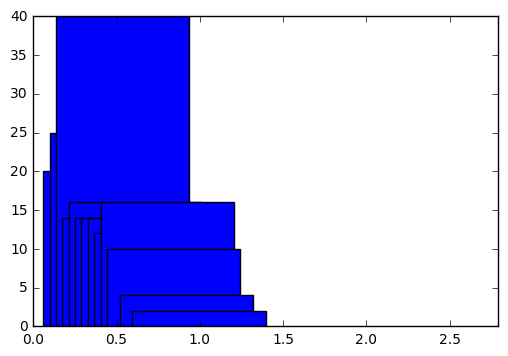

In [14]:
hist, bin_edges = np.histogram(wo_f, bins = 'sqrt')
plt.bar(bin_edges[:-1], hist)
plt.xlim(0, 2*w_f.max())
plt.show()

D:\Software\Anaconda3\lib\site-packages\matplotlib\__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


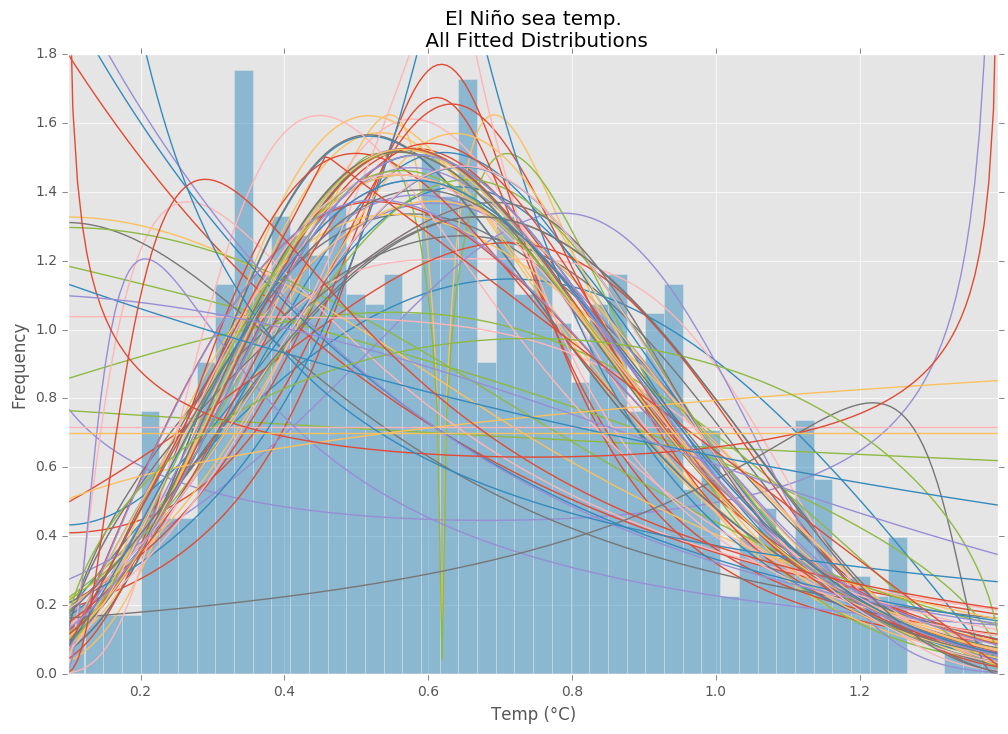

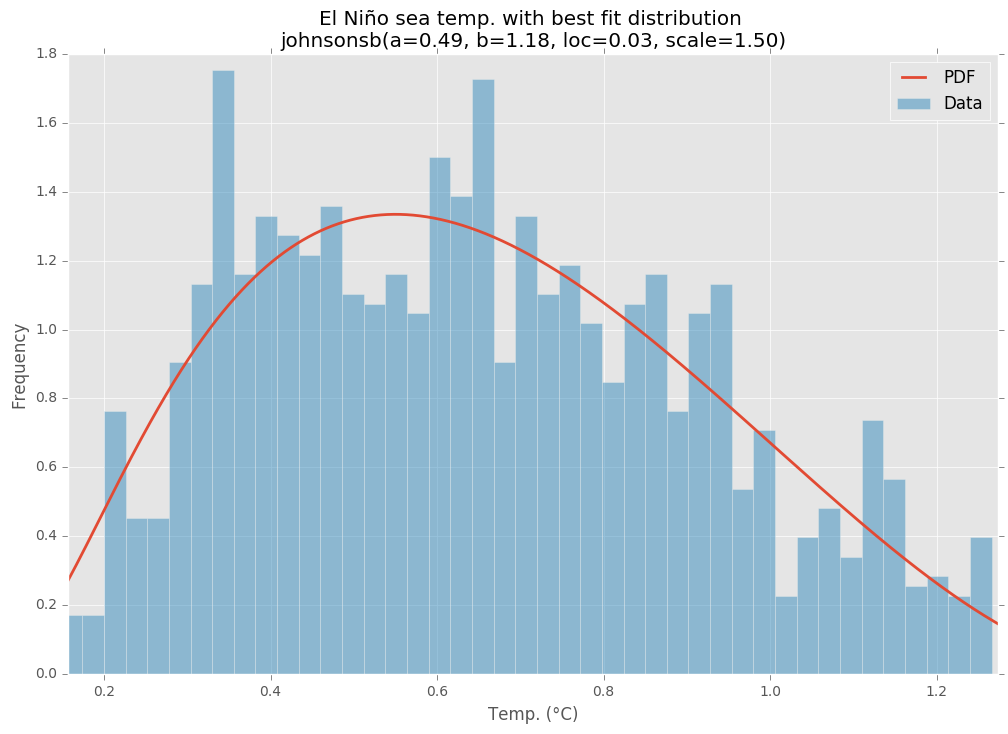

In [15]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in tq(DISTRIBUTIONS):

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(w_f)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(w_f, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

D:\Software\Anaconda3\lib\site-packages\matplotlib\__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


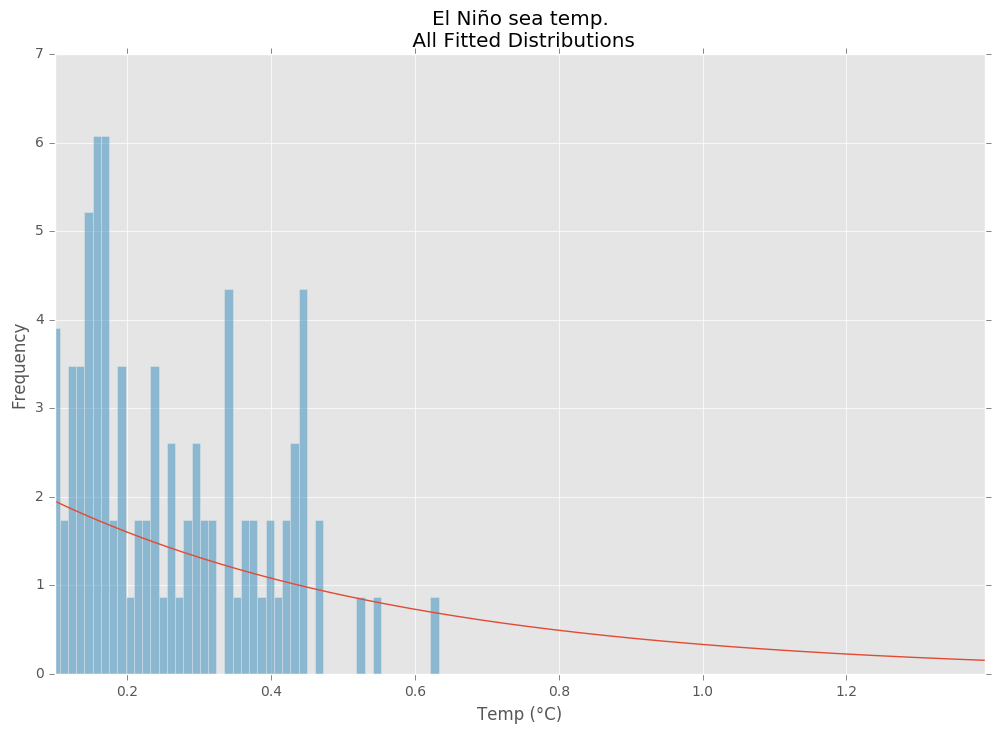

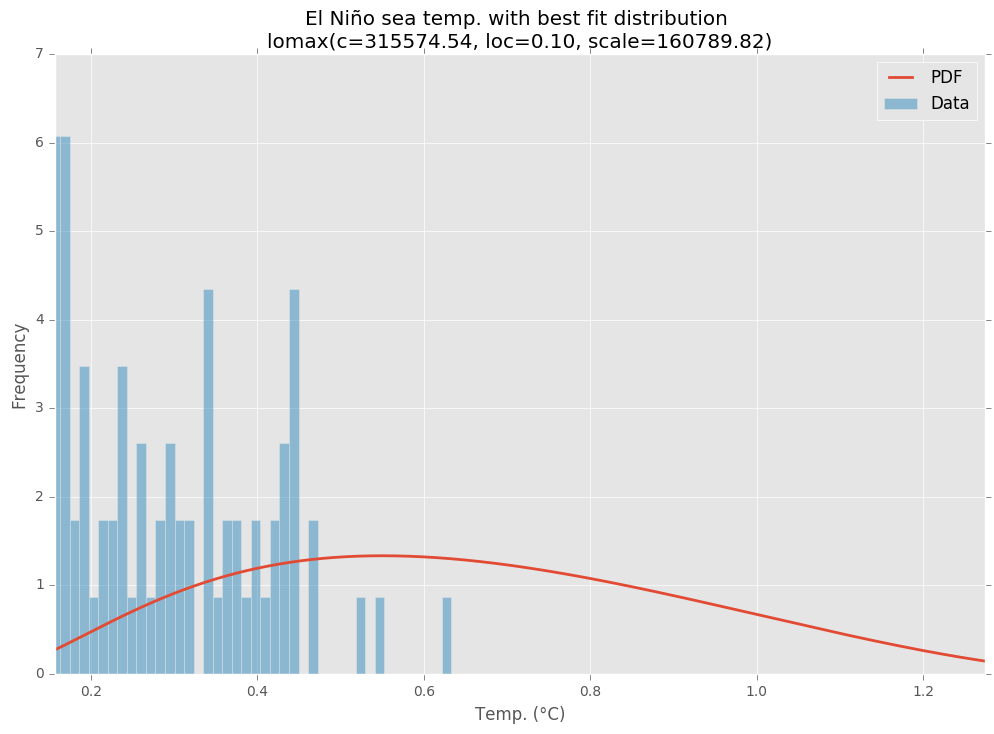

In [16]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions t,st.levyo check
#    DISTRIBUTIONS = [     ,st.mielke,st.nakagami,st.ncx2,st.ncf,   
#       st.gilbrat,st.lomax
#    ]        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        #st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
    DISTRIBUTIONS = [        
         st.lomax#st.gilbrat,
    ]
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in tq(DISTRIBUTIONS):

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (st.lomax.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(wo_f)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(w_f, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF
pdf1 = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

D:\Software\Anaconda3\lib\site-packages\matplotlib\__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


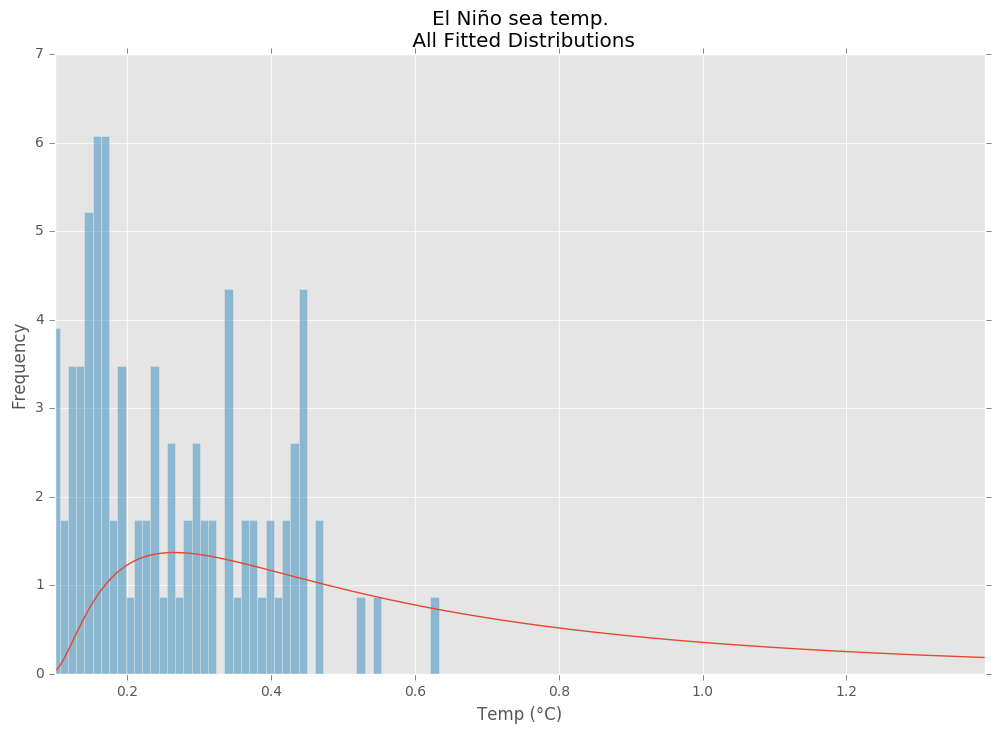

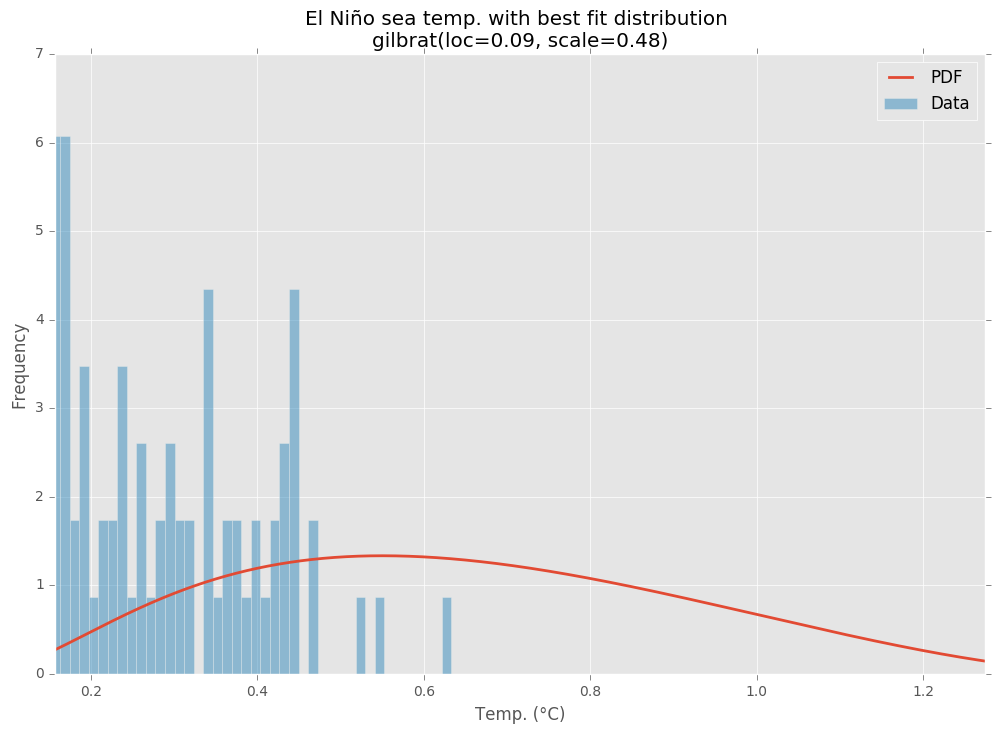

In [17]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions t,st.levyo check
#    DISTRIBUTIONS = [     ,st.mielke,st.nakagami,st.ncx2,st.ncf,   
#       st.gilbrat,st.lomax
#    ]        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        #st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
    DISTRIBUTIONS = [        
         st.gilbrat#,st.lomax
    ]
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in tq(DISTRIBUTIONS):

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(wo_f)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(w_f, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF
pdf2 = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

x :0.232111304648
INTEGRAL PDF at x : 0.05
INTEGRAL PDF at x : 0.7708


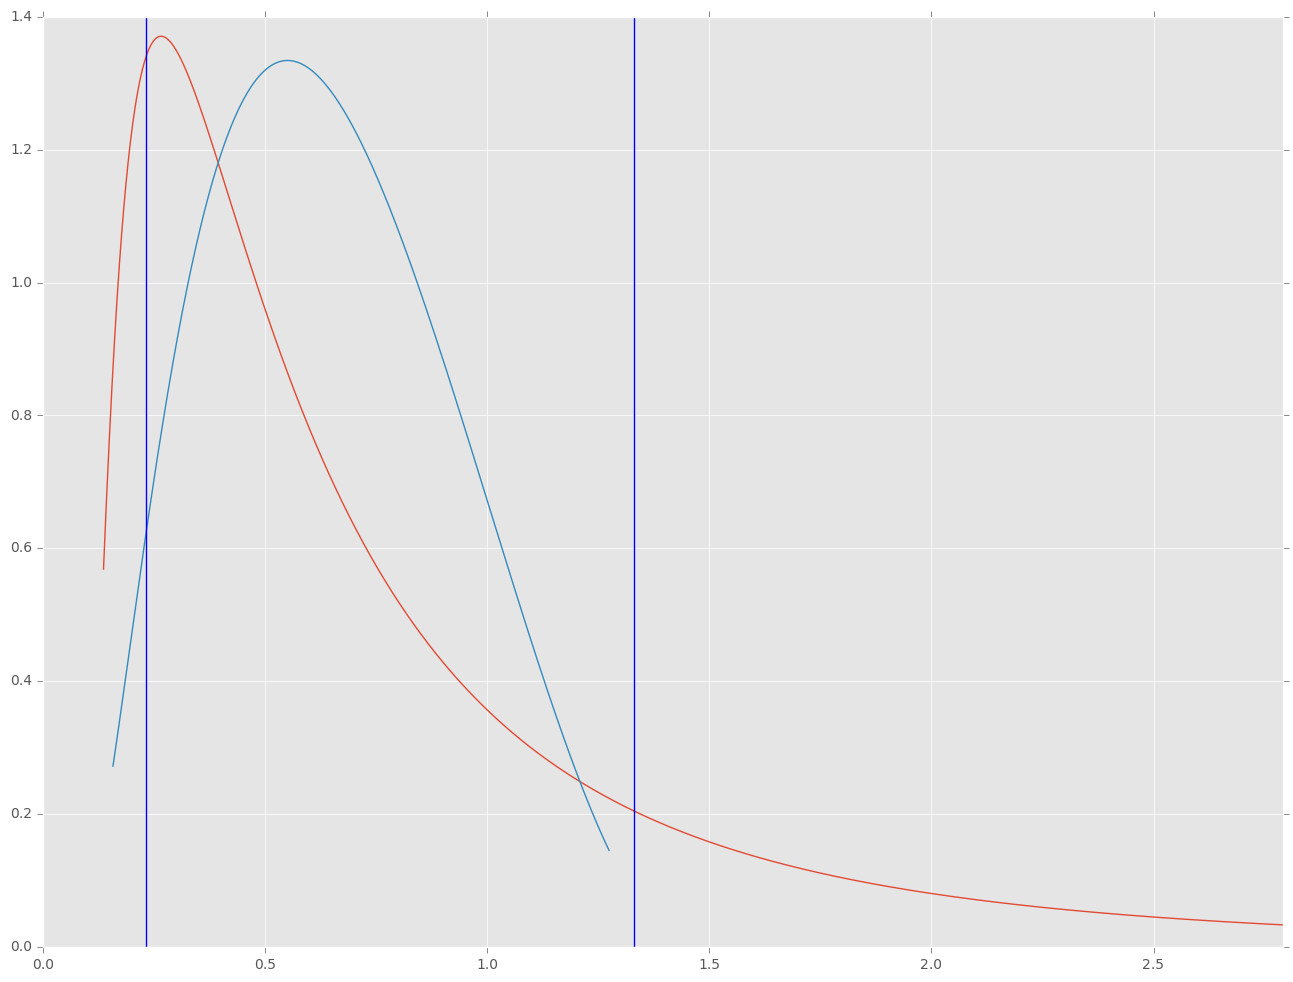

In [18]:
MAX_NOF = wo_f.max()
MIN_F = w_f.min()
plt.figure()
plt.plot(pdf2)
plt.plot(pdf)
plt.xlim(0, 2*w_f.max())
x=np.percentile(pdf,5)
y=np.percentile(pdf,95)
#y = np.percentile(pdf1,26)
#print('y :'+str(y))
print('x :'+str(x))
plt.axvline(x=x)
plt.axvline(x=y)
print('INTEGRAL PDF at x : '+str(pdf[(pdf<=x)].count()/len(pdf)))
print('INTEGRAL PDF at x : '+str(pdf2[(pdf2<=x)].count()/len(pdf2)))
plt.show()

99 6
1.33421682034 0.25132235856


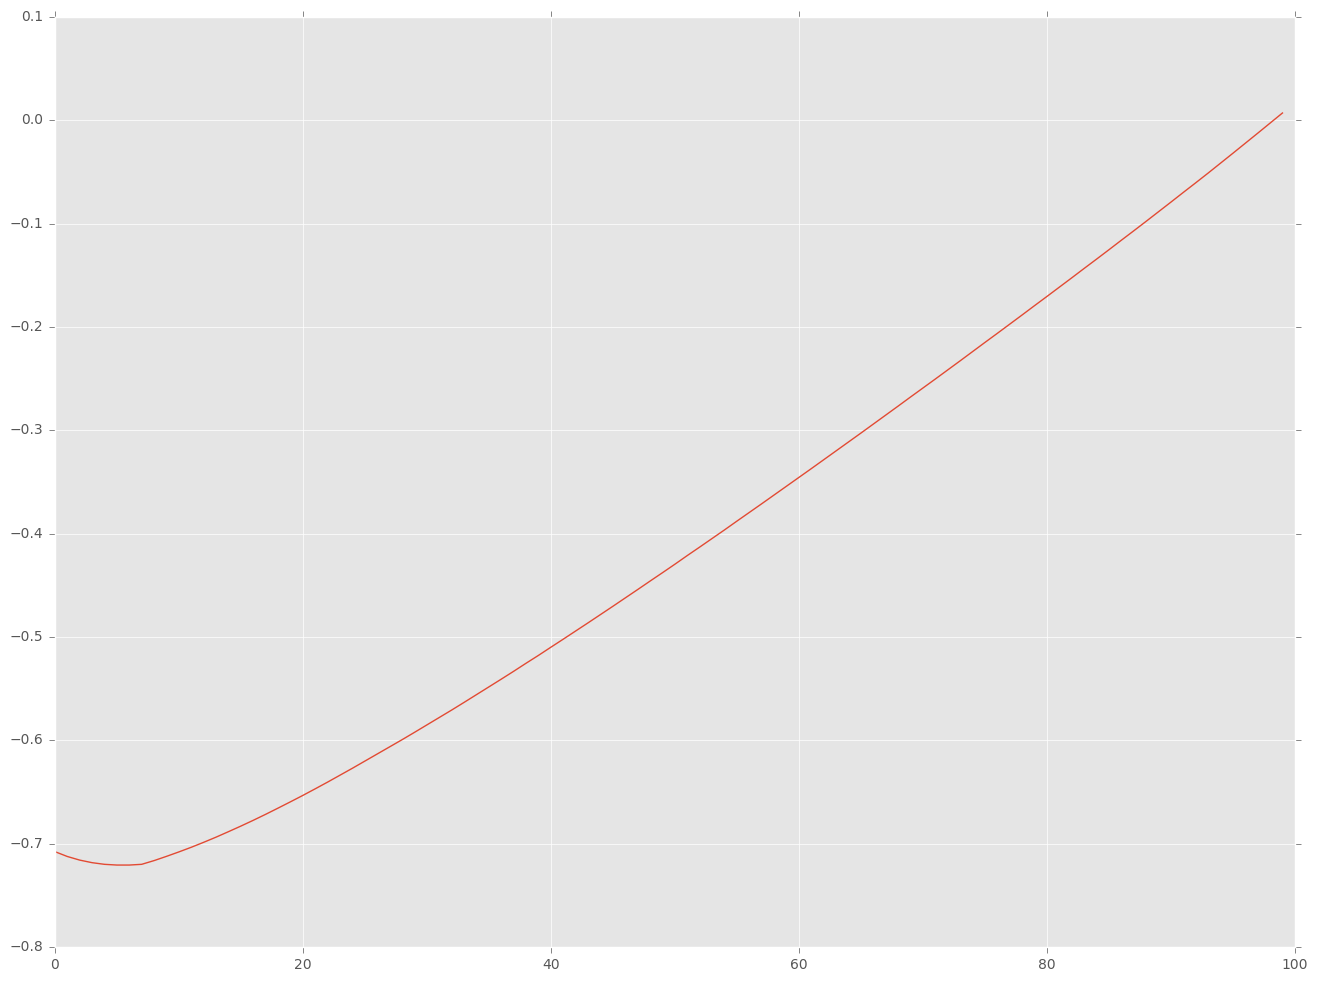

In [19]:
distance = []
for i in range(0,100):
    x=np.percentile(pdf,i)
    pdf1[(pdf1<x)].count()/len(pdf1)
    distance.append(pdf[(pdf<x)].count()/len(pdf)-pdf2[(pdf2<x)].count()/len(pdf2))
distance = np.array(distance)
plt.figure()
plt.plot(distance)
k_max = np.where(distance==distance.max())[0][0]
k_min = np.where(distance==distance.min())[0][0]
print(k_max,k_min)
TH_FISH_MM = x=np.percentile(pdf,k_max)
TH_NO_FISH_MM = x=np.percentile(pdf,k_min)
print(TH_FISH_MM,TH_NO_FISH_MM)
#print(distance.max(),distance[np.where(distance == distance.max())])

In [21]:
# MEASURE ACCURANCY OF THRESHOLD
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
    for i in range(len(y_hat)): 
        if y_hat[i]==1 and y_actual!=y_hat[i]:
           FP += 1
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TN += 1
    for i in range(len(y_hat)): 
        if y_hat[i]==0 and y_actual!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

<h1> DISPLAY TEST PREDICTION </h1>

In [22]:
# VALUES TO BE ALMOST SURE FOR EXCLUSION : RESULTAT .
TH_PARAMS = {'TH_NO_FISH_MM':TH_NO_FISH_MM}

In [10]:
for X, Y, W , paths in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size, with_name=True, seed=6):
    break

In [12]:
Z = model.predict(X)

In [15]:
importlib.reload(htr)
importlib.reload(utils)
importlib.reload(meta)
importlib.reload(h_gen)

<module 'h_gen' from '../python_scripts\\h_gen.py'>

In [ ]:
for i in range(4,8):
    print(paths[i])
    plt.imshow(load_img(paths[i]))
    plt.show()
    maxs = []
    for j in range(5):
        plt.figure(figsize=(24,24))
        plt.subplot(1,2,1)
        plt.imshow(np.reshape(Y[j][i],mask_size[1]))
        plt.subplot(1,2,2)
        plt.imshow(np.reshape(Z[j][i],mask_size[1]))
        plt.show()
        print("max: ", np.max(Z[j][i]))
        print("min: ", np.min(Z[j][i]))
        maxs.append(maxs)
    mean_max = np.array(maxs).mean()
        
    masks = np.array([np.reshape(Z[j][i],mask_size[1]) for j in range(5)])
    print(masks.shape)
    #rectangles = htr.find_rectangles([masks],mean_max,TH_PARAMS, threshold=100, ranges=(2,20), clip=0.20, debug=True,
    #                    border_conf=[(11,3),(71,10)], batch_size=1, max_fish=10)

In [13]:
for X, Y, W , paths,is_rects in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size, with_name=True, shuffle=False,debug2=True):
    break

In [11]:
file = './models/yoloduswag.h5'
model = load_model(file)

In [14]:
Z = model.predict(X)

In [15]:
importlib.reload(htr)

<module 'heatmaps_to_rect' from '../python_scripts\\heatmaps_to_rect.py'>

../train/train/YFT/img_04469.jpg


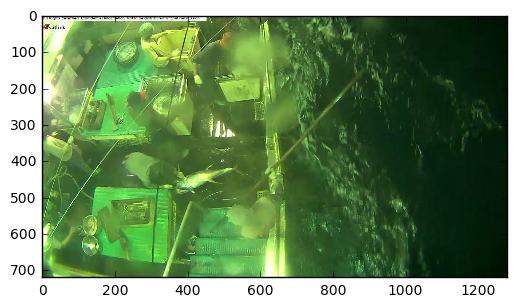

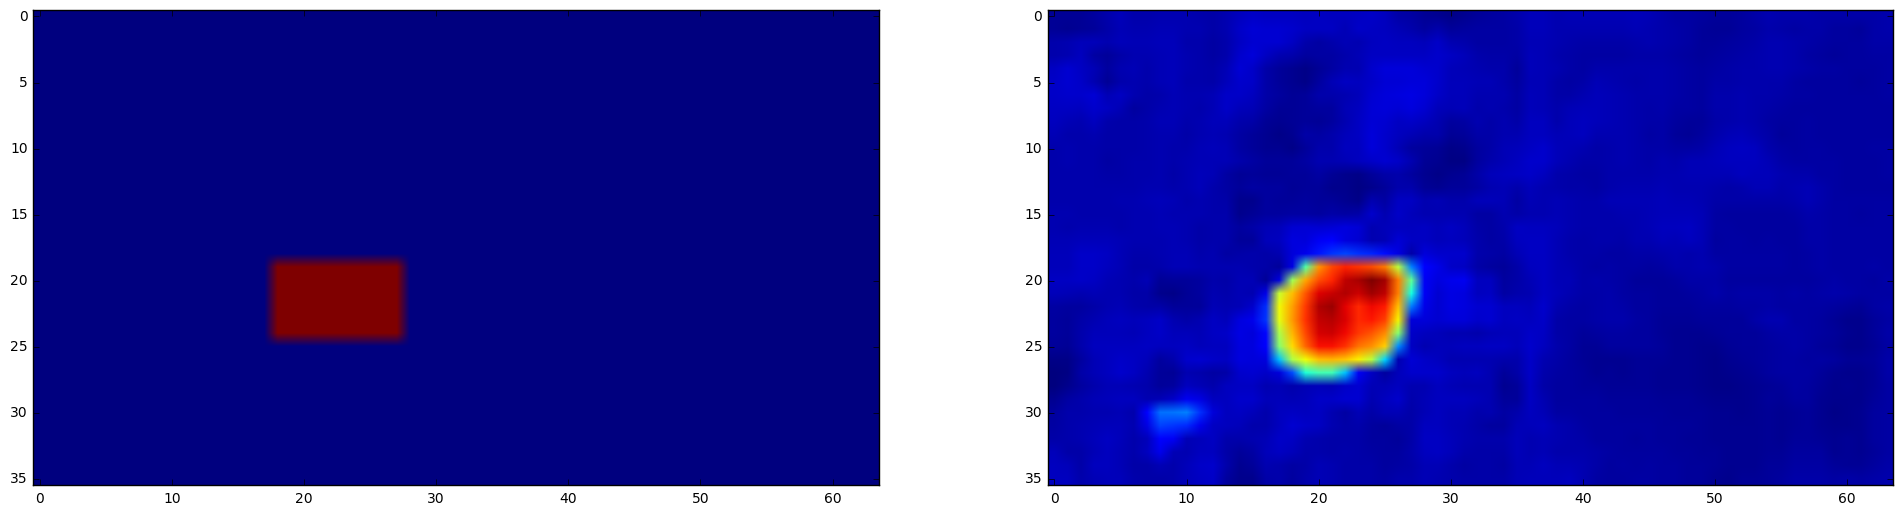

max:  0.900427
min:  -0.0387458


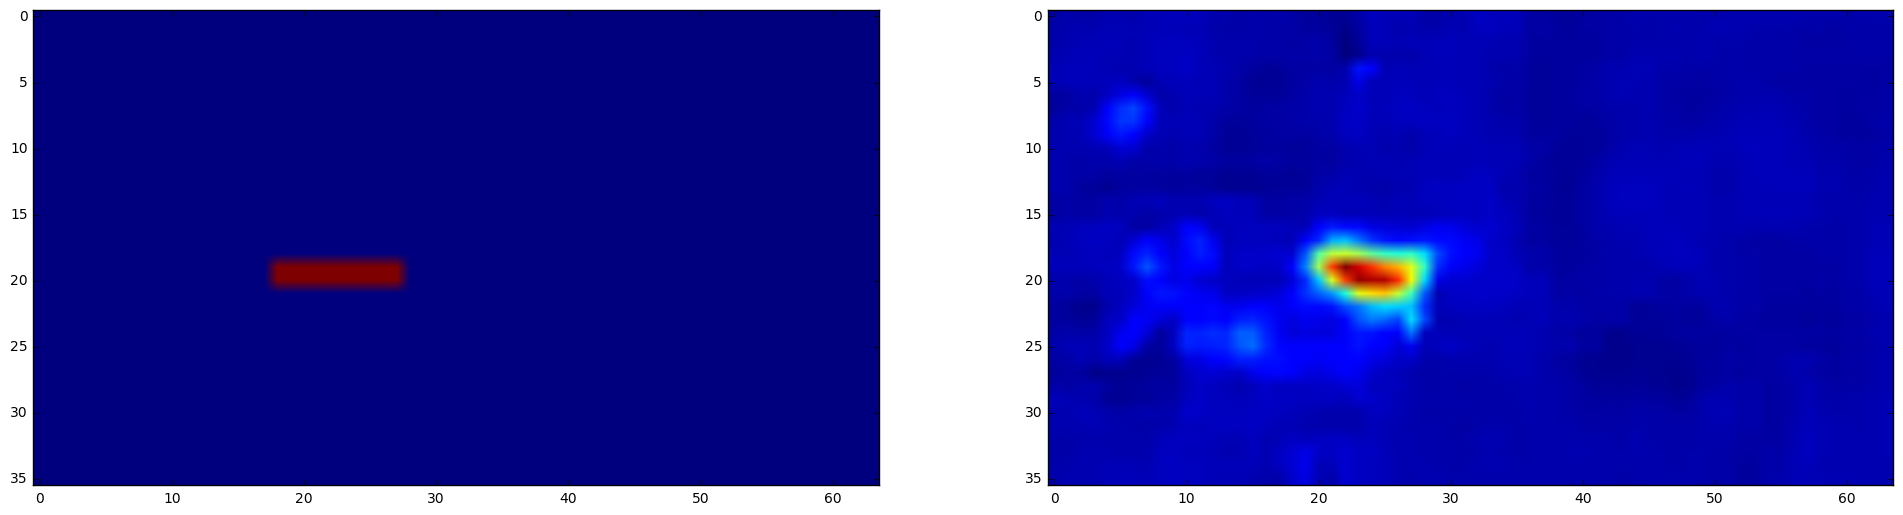

max:  0.697239
min:  -0.0319953


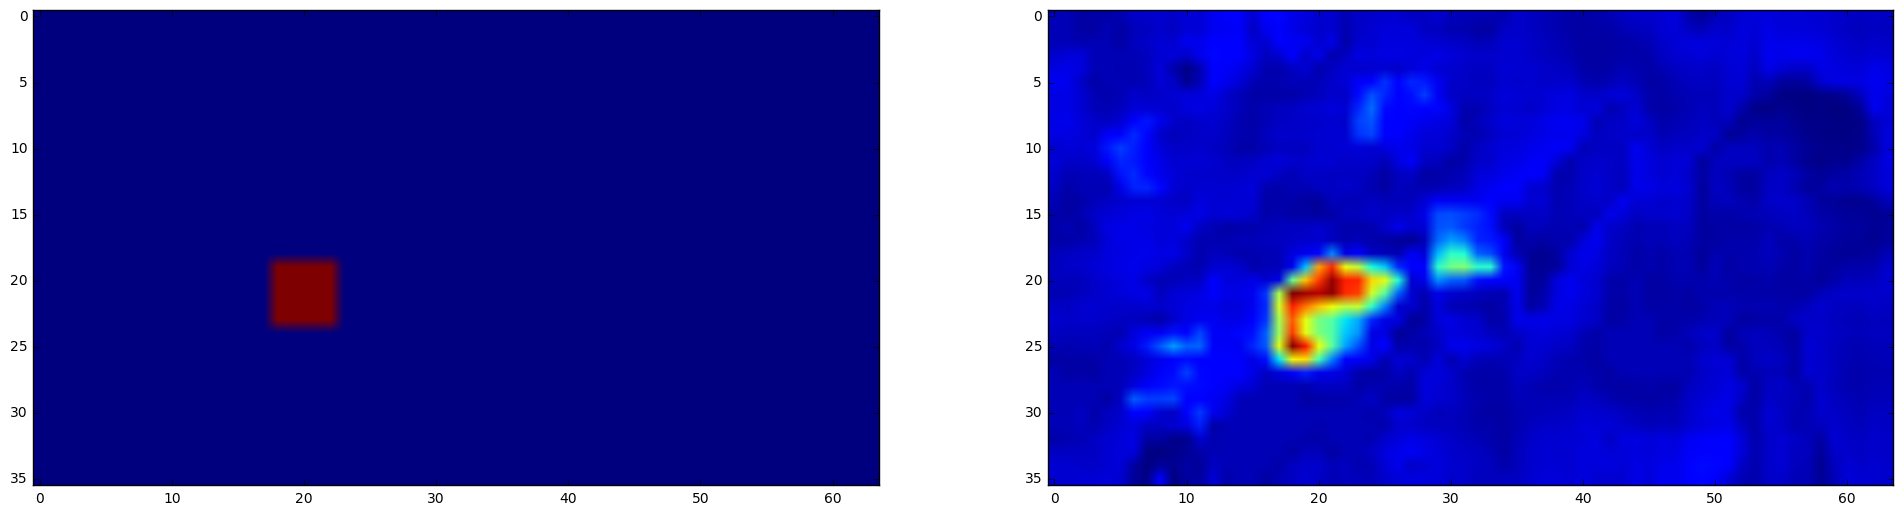

max:  0.273881
min:  -0.00812543


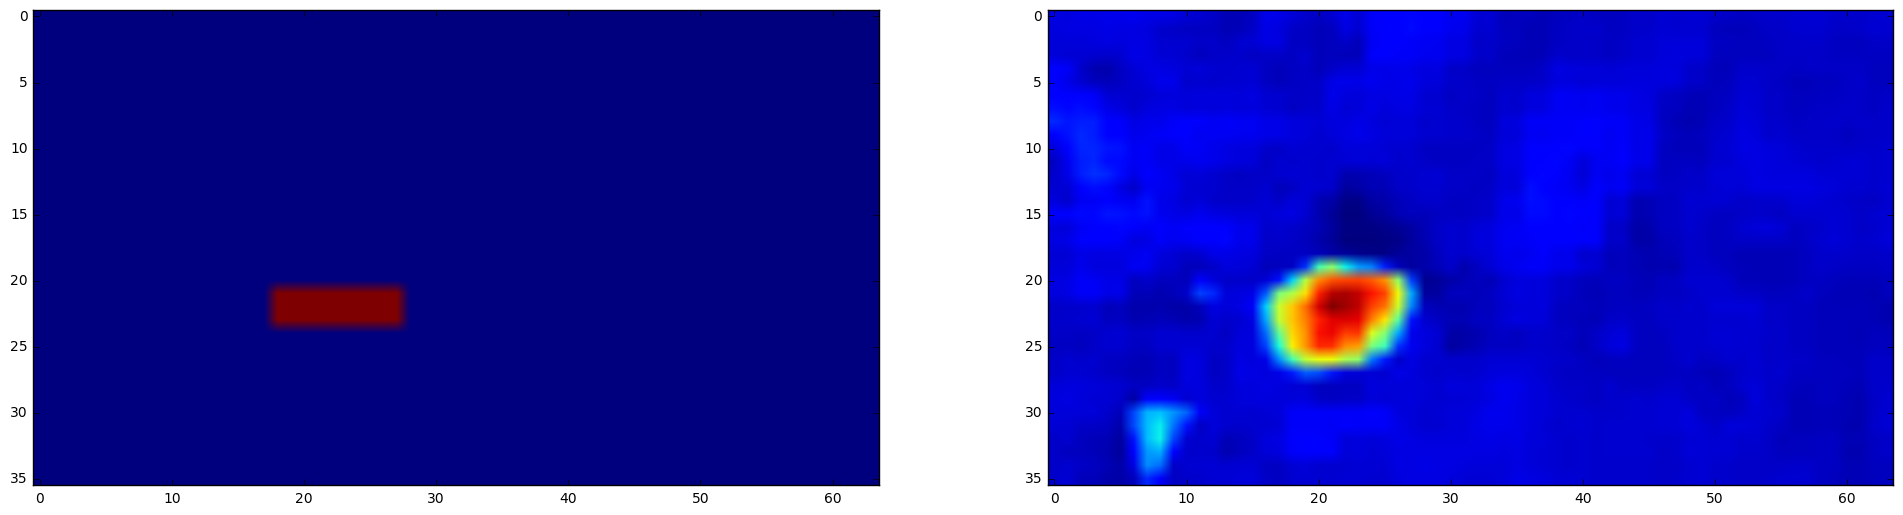

max:  0.586777
min:  -0.049363


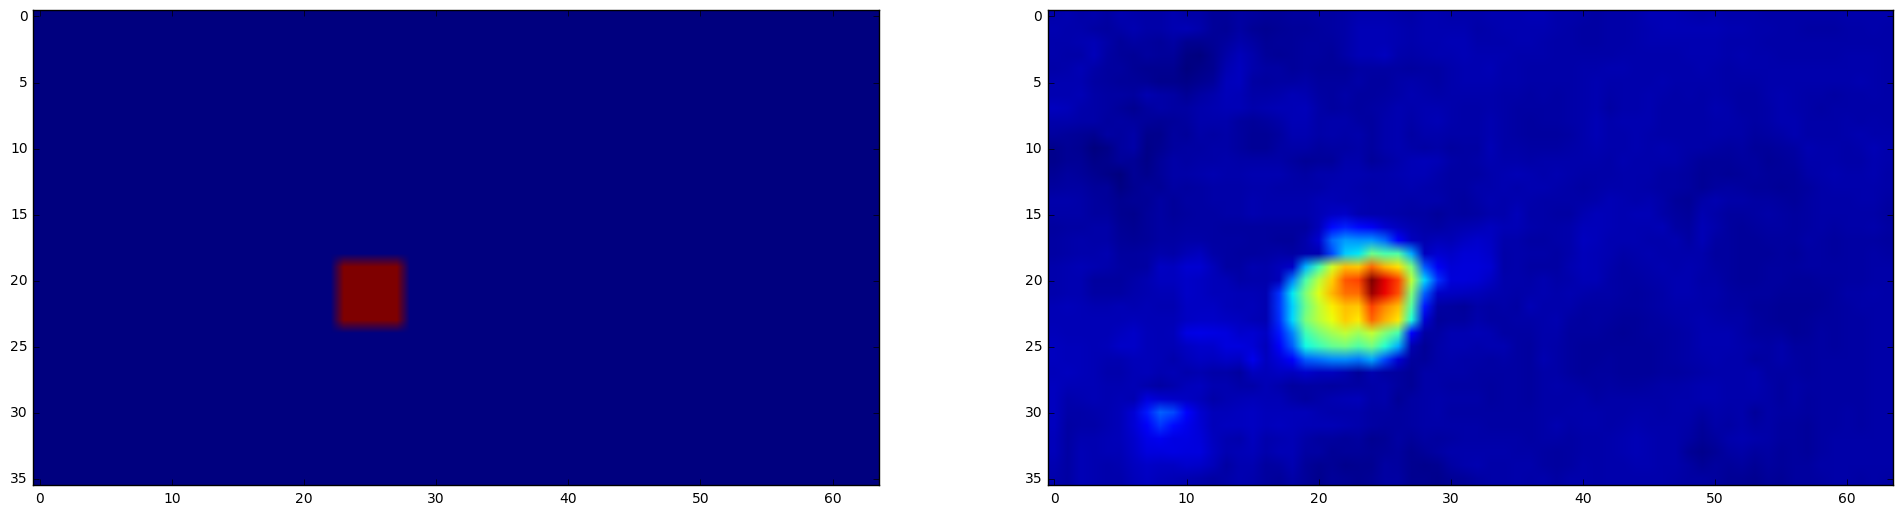

max:  0.869319
min:  -0.0339804
(5, 36, 64)
../train/train/ALB/img_05604.jpg


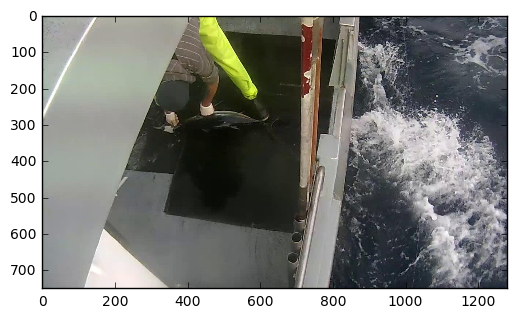

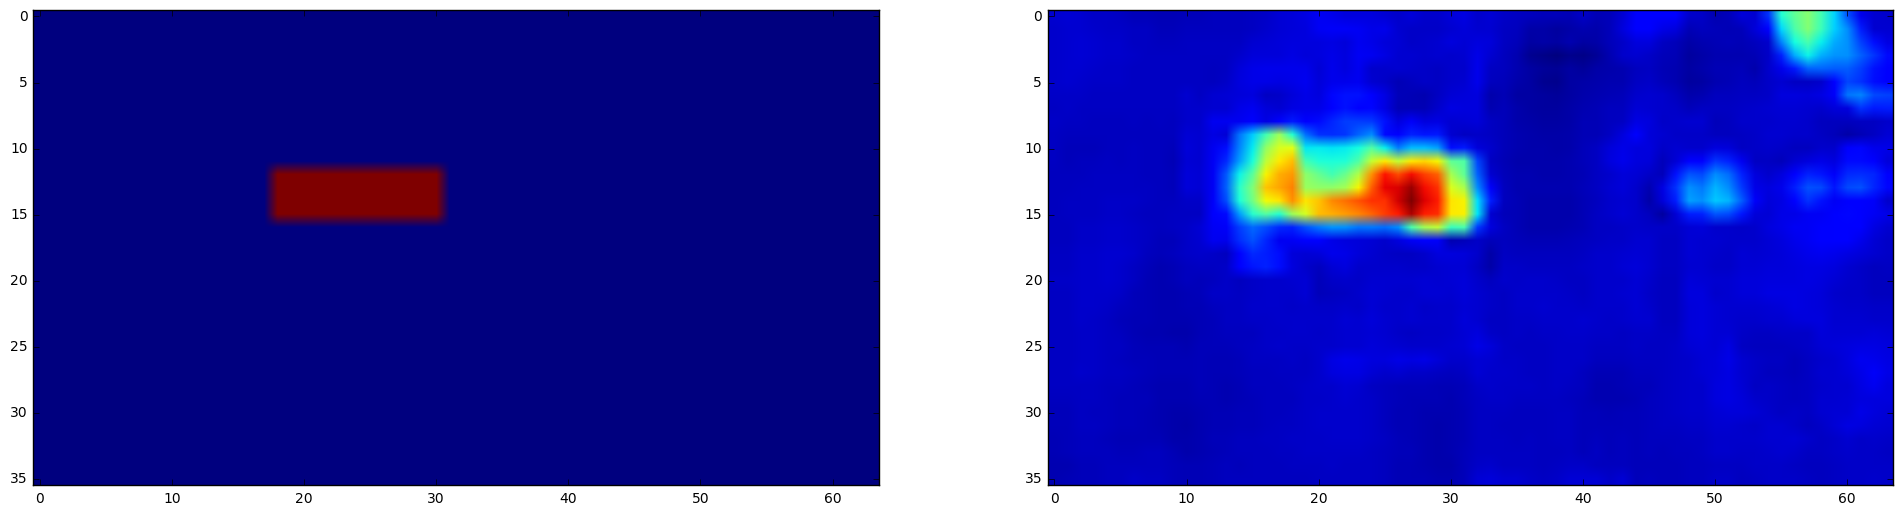

max:  0.690834
min:  -0.0499128


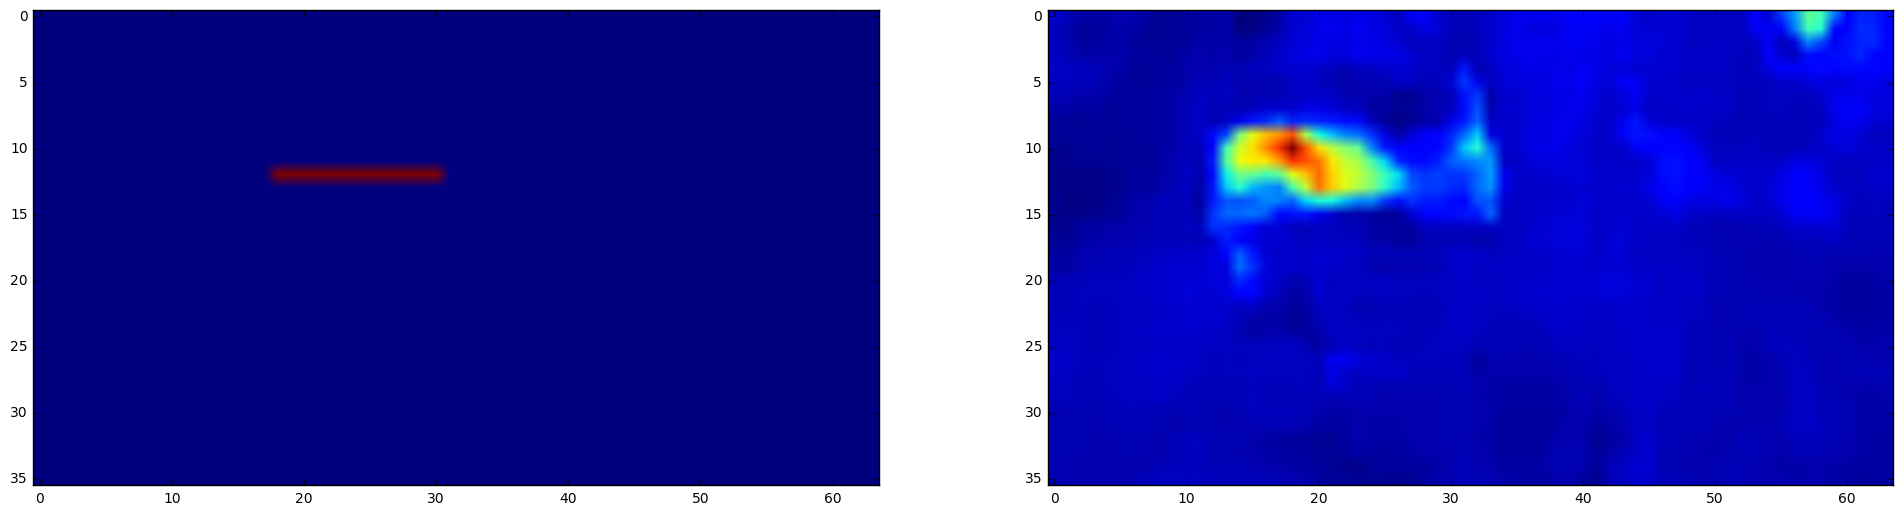

max:  0.49457
min:  -0.0306947


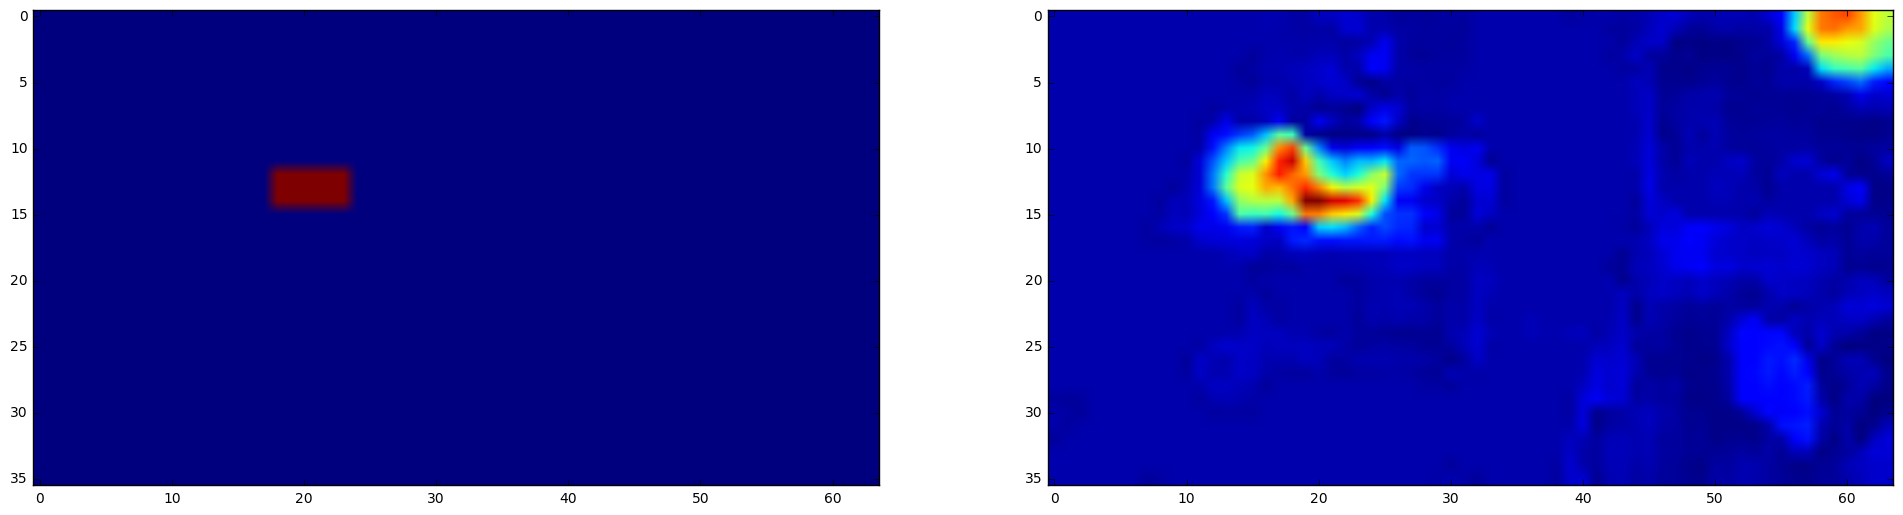

max:  0.312177
min:  -0.00739028


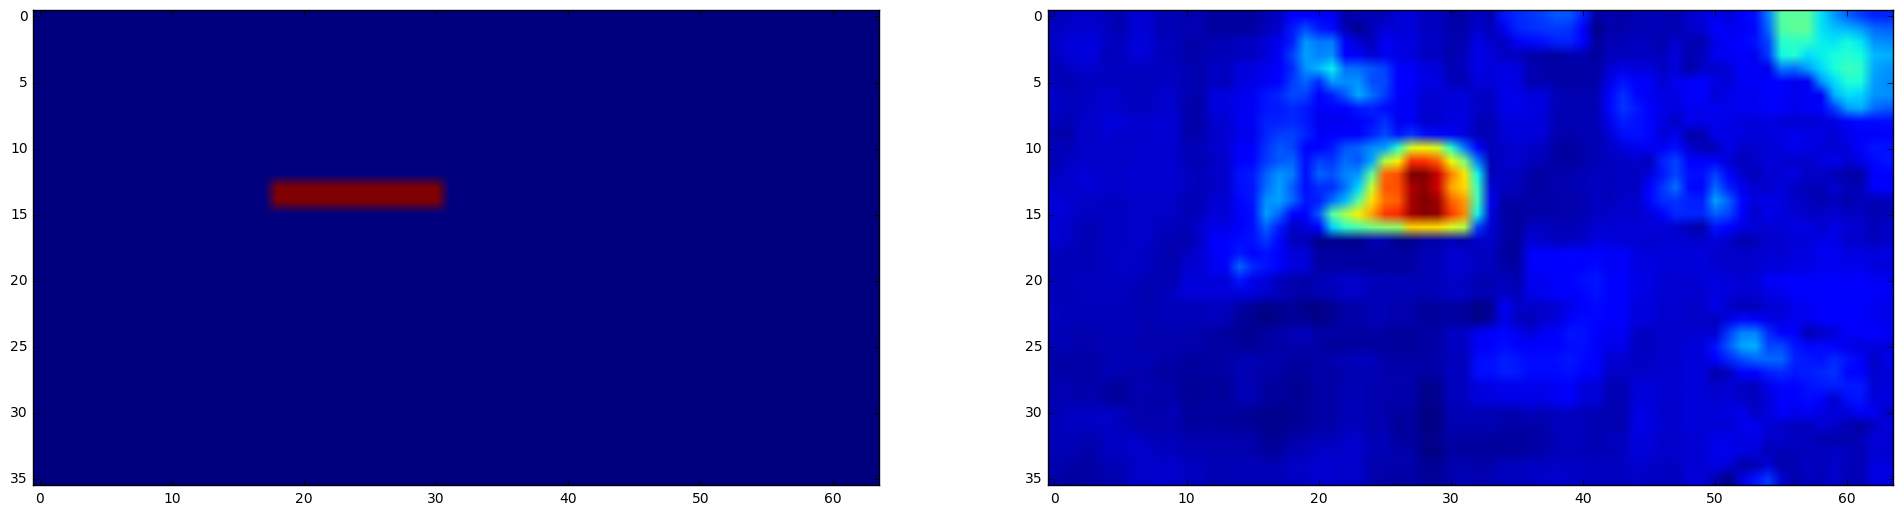

max:  0.460007
min:  -0.0390581


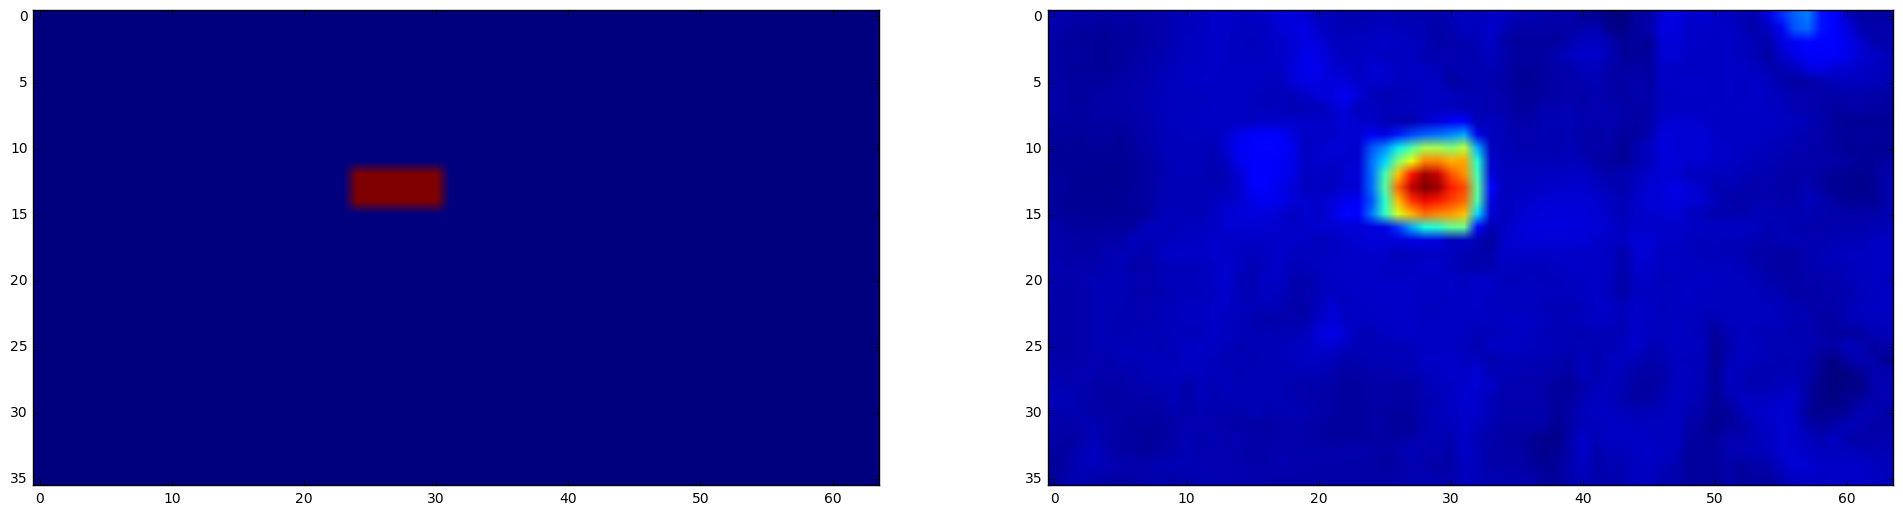

max:  0.661468
min:  -0.0337587
(5, 36, 64)
../train/train/ALB/img_07885.jpg


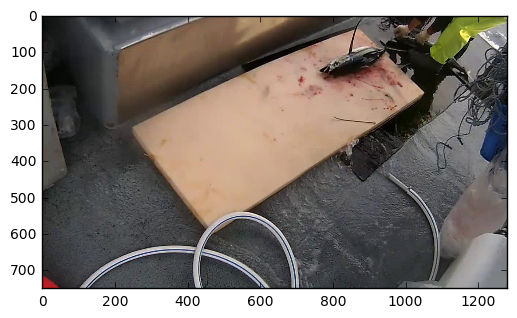

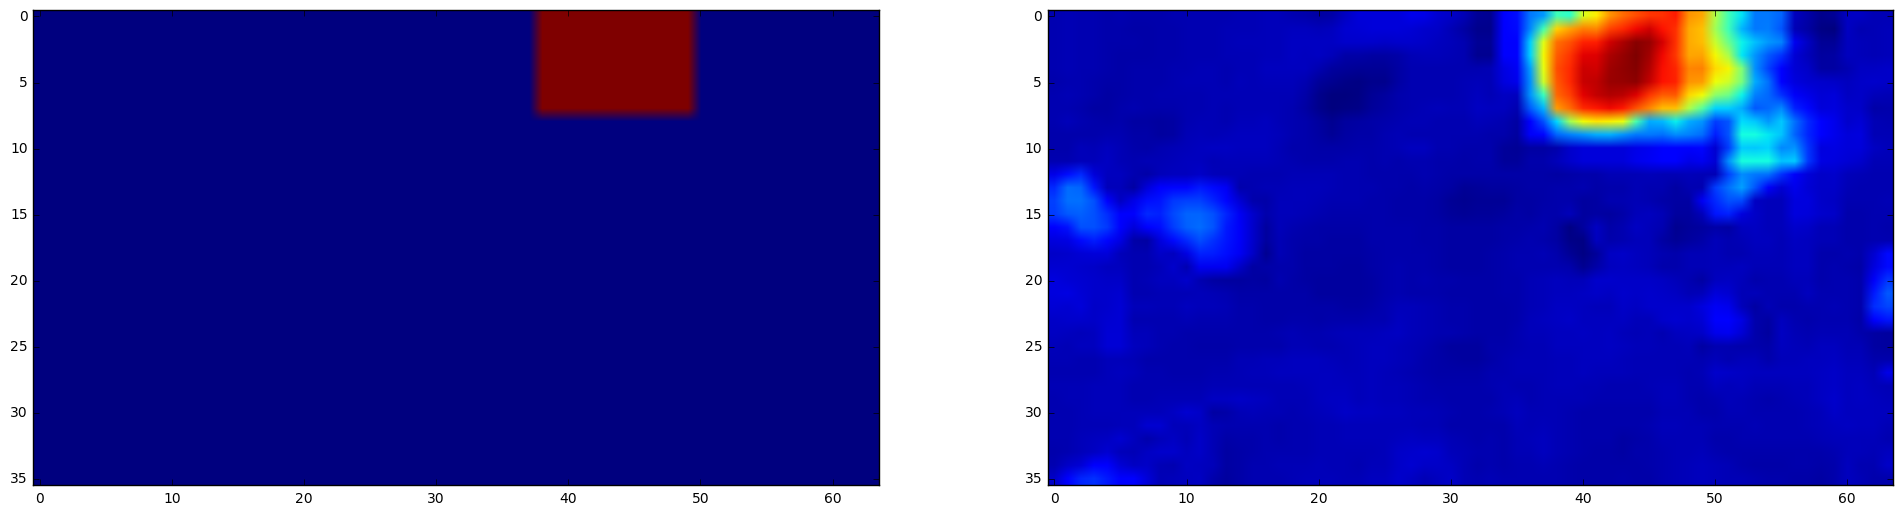

max:  1.07236
min:  -0.0469012


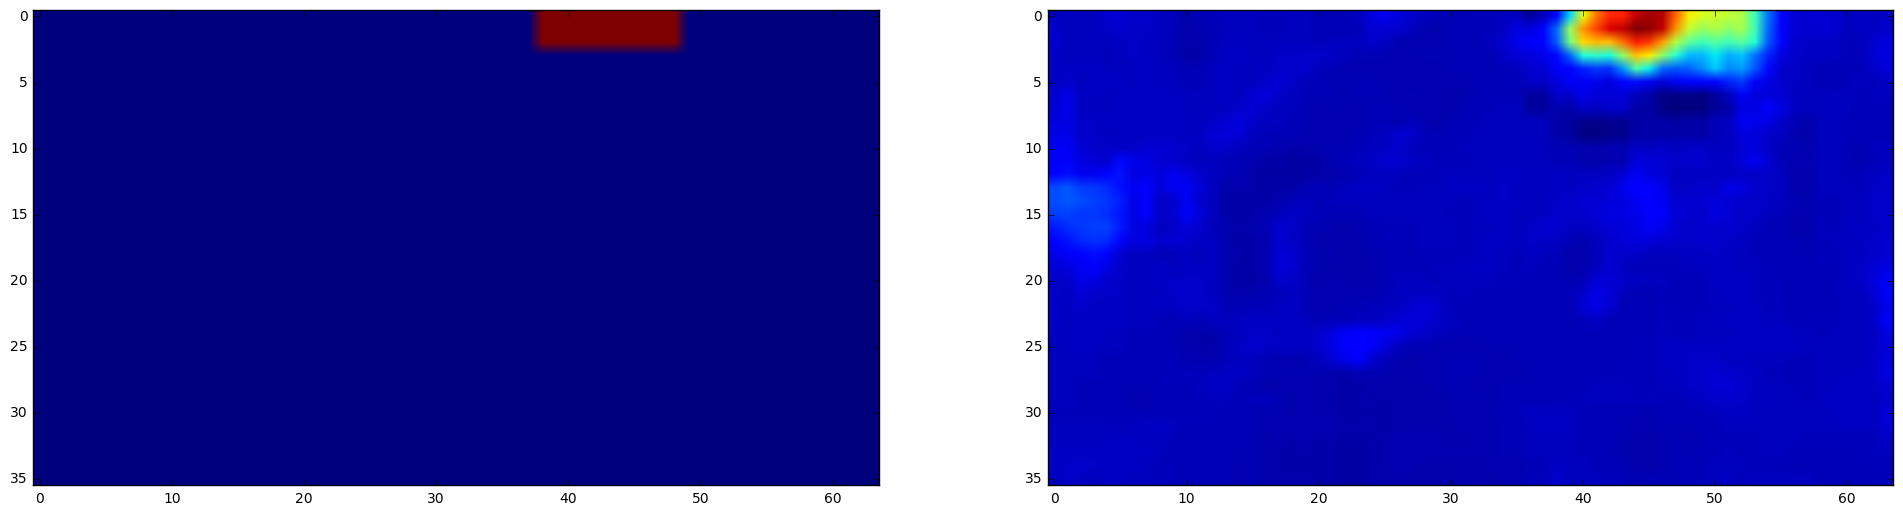

max:  0.941082
min:  -0.0595947


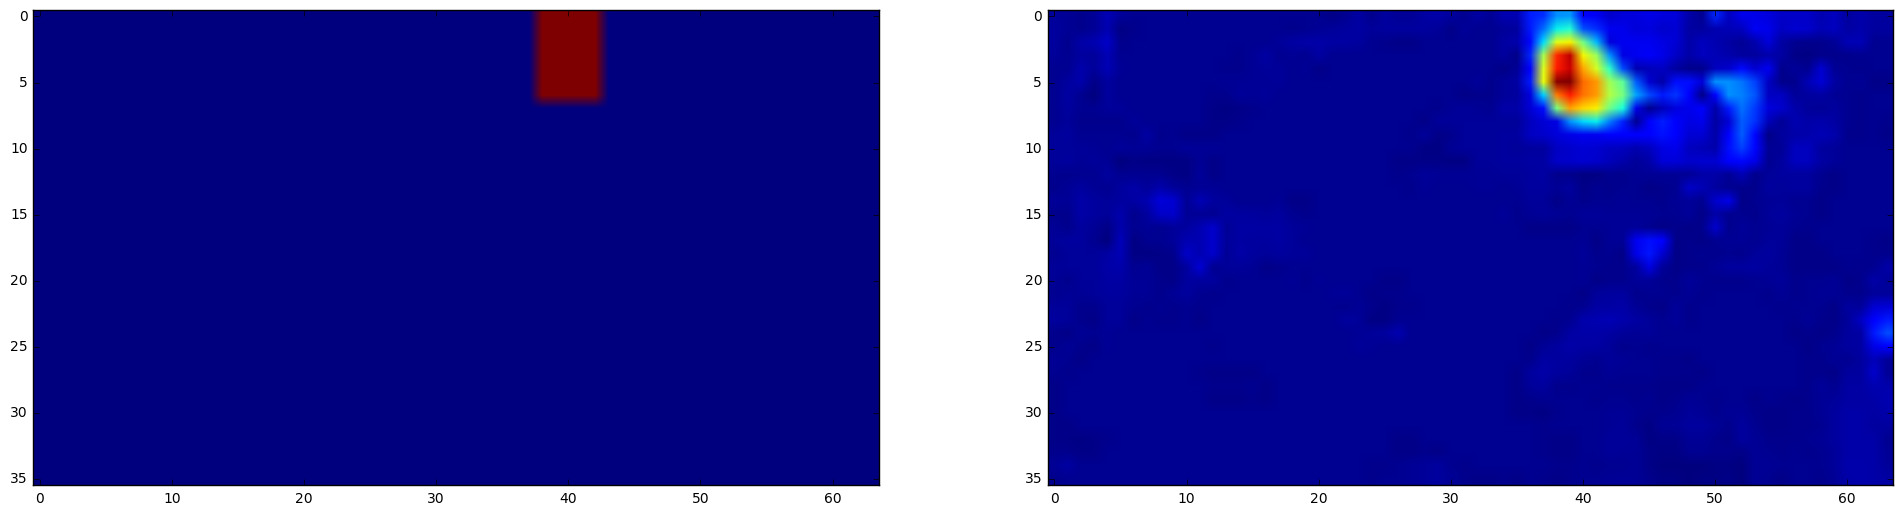

max:  0.638037
min:  -0.005184


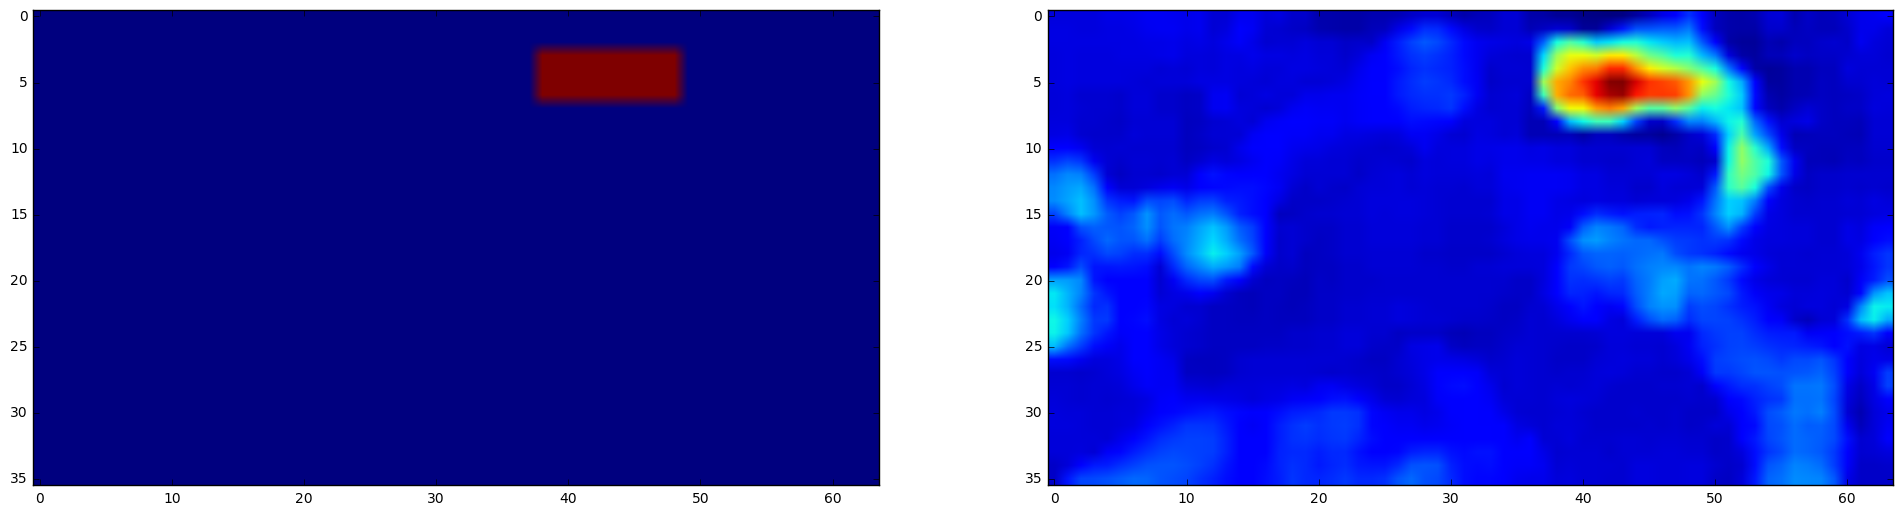

max:  1.02353
min:  -0.0896165


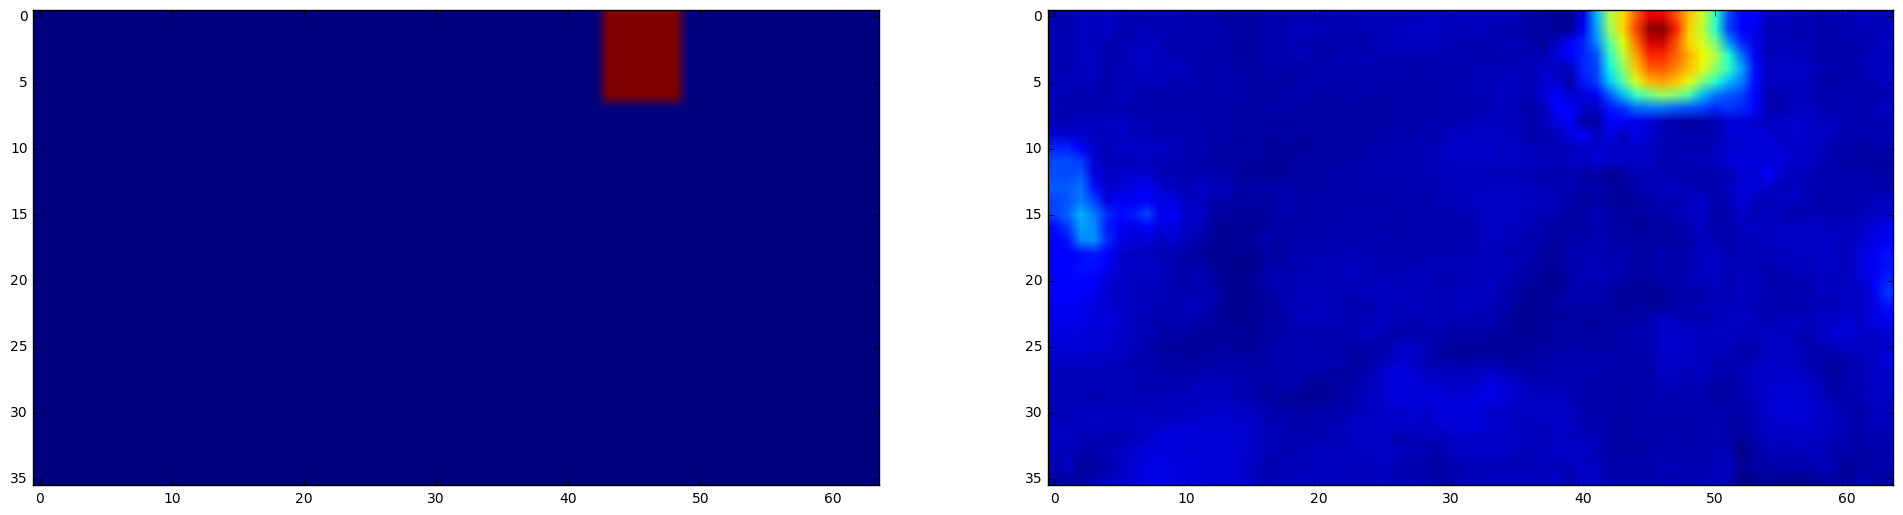

max:  1.00482
min:  -0.0535994
(5, 36, 64)
../train/train/YFT/img_03121.jpg


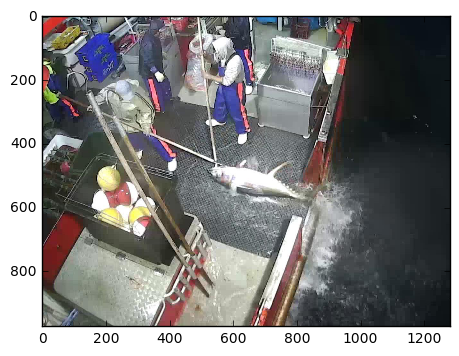

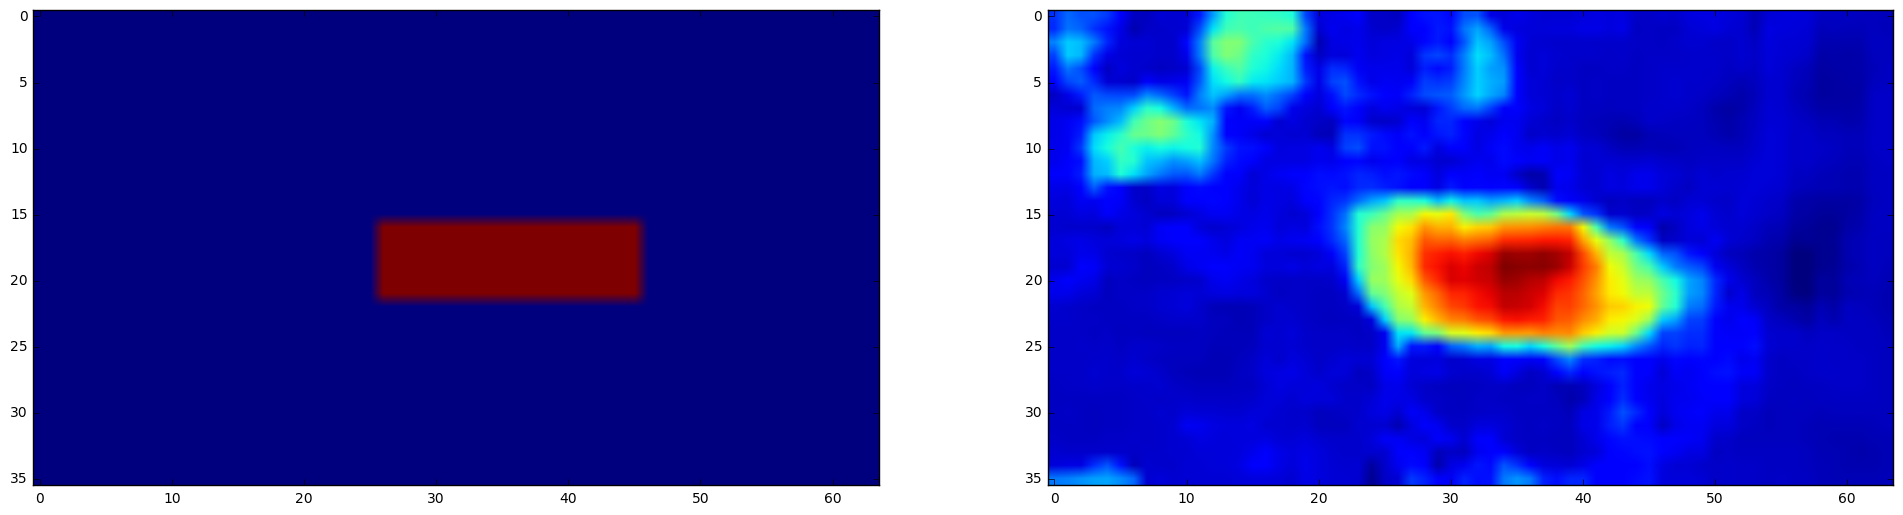

max:  0.867604
min:  -0.0593534


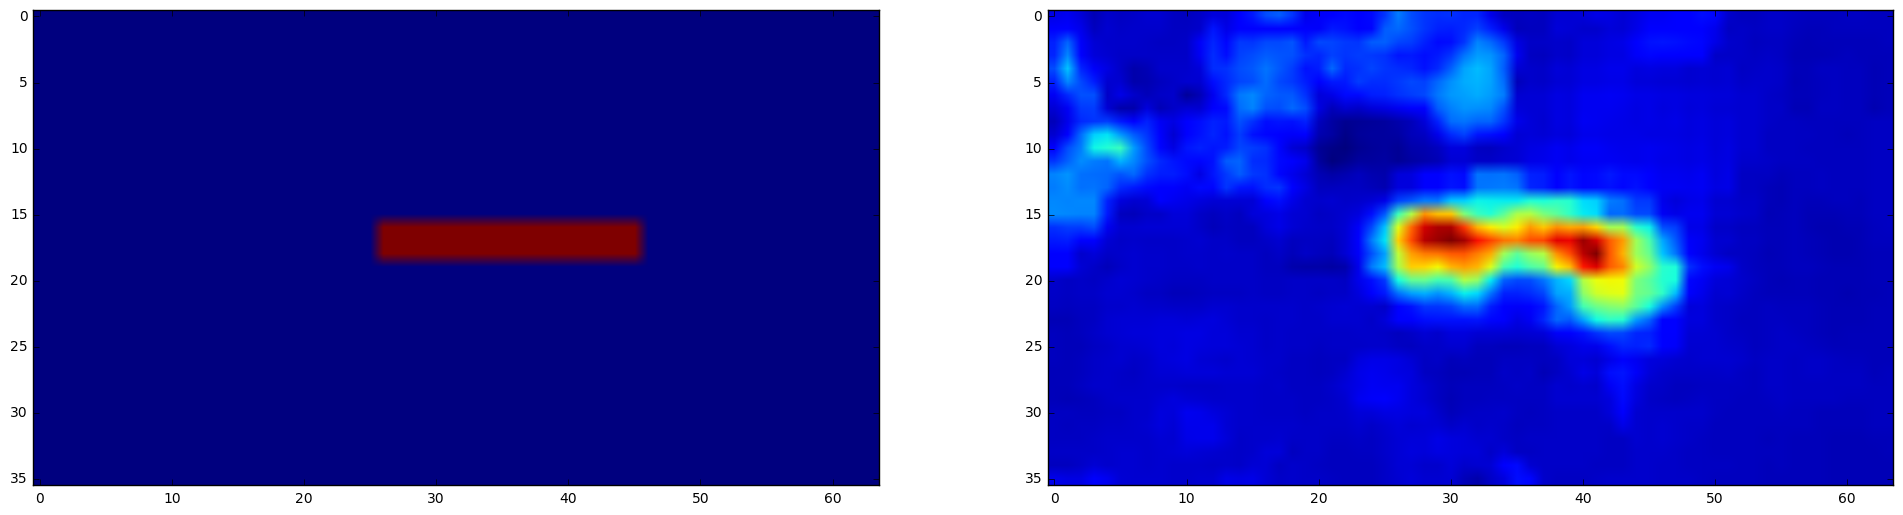

max:  0.880208
min:  -0.0580007


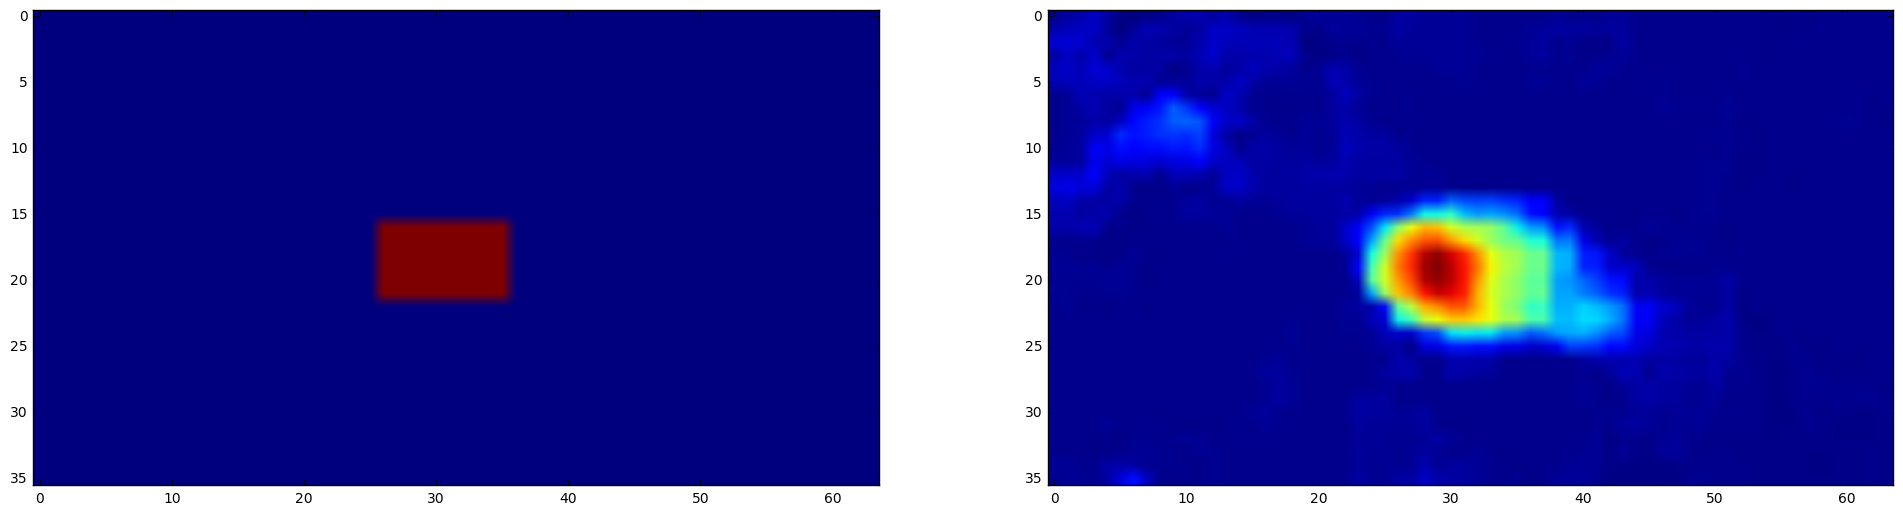

max:  0.967134
min:  -0.00819577


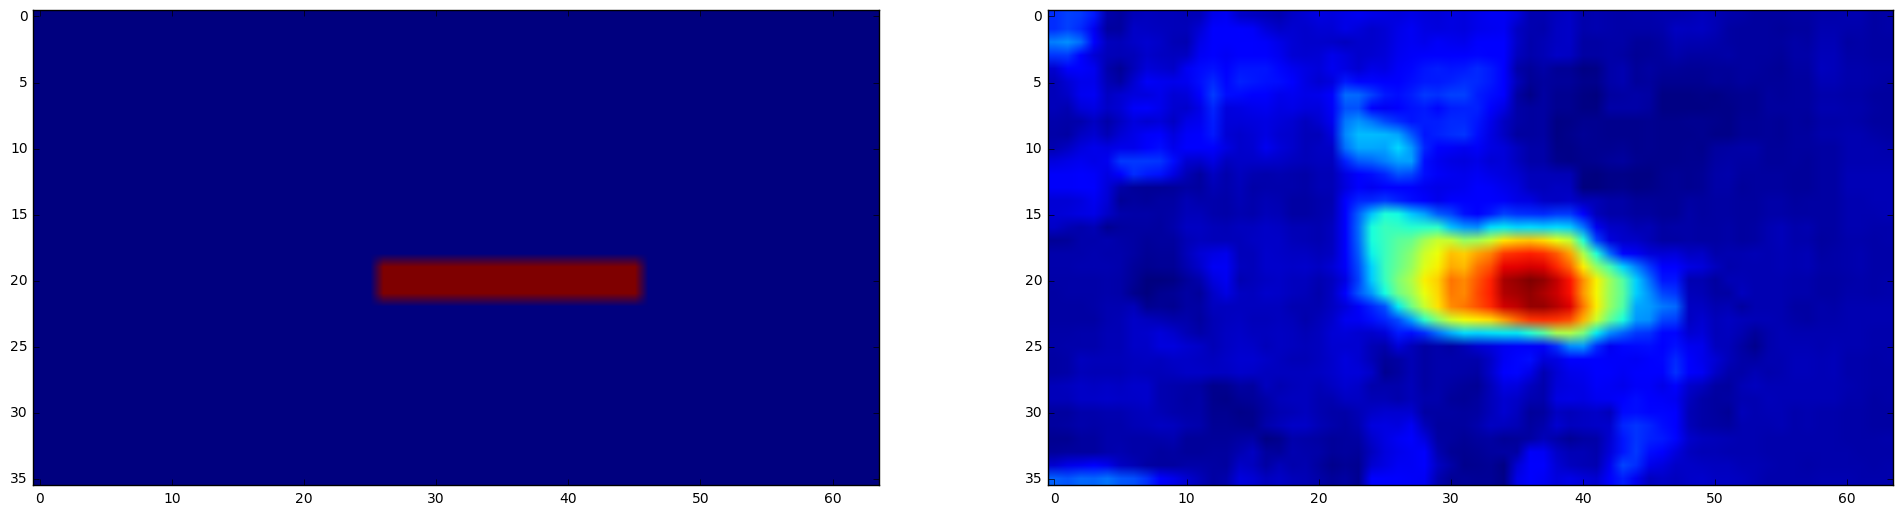

max:  0.928805
min:  -0.0427807


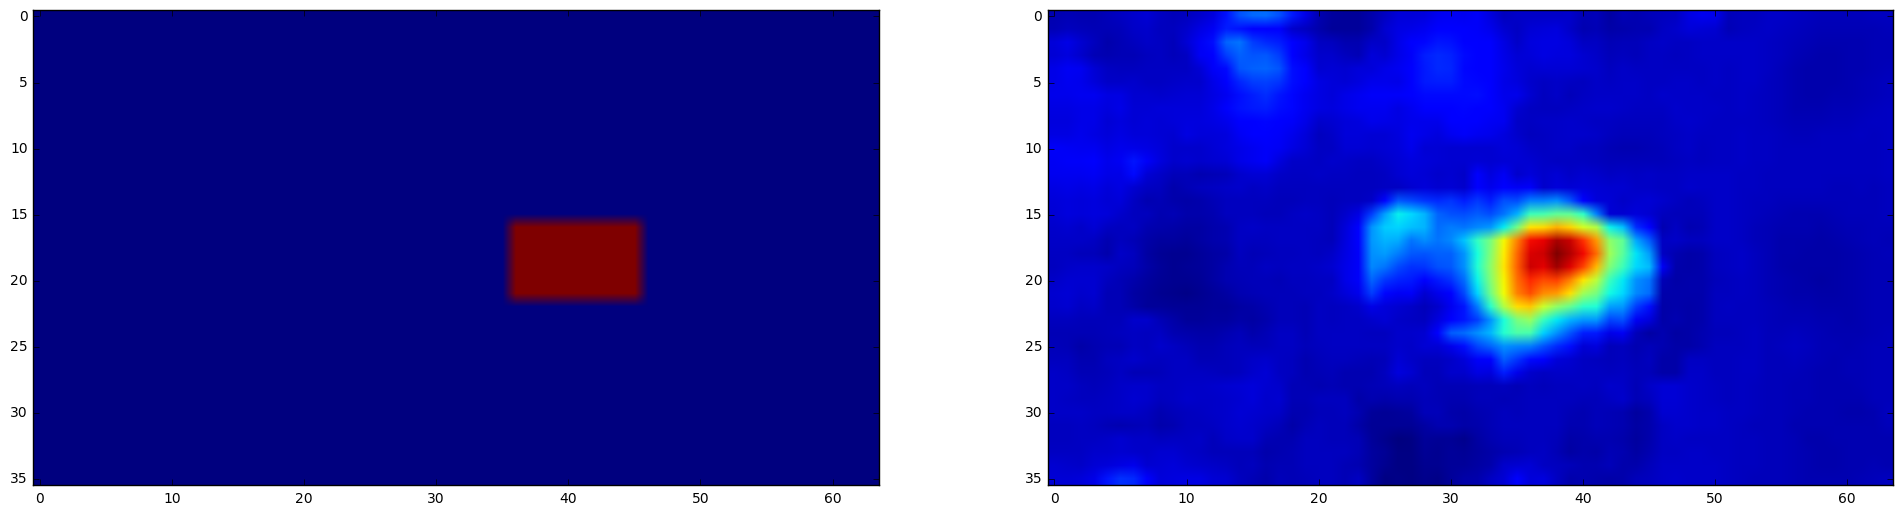

max:  1.01127
min:  -0.0601272
(5, 36, 64)


In [16]:
for i in range(4):
    print(paths[i])
    plt.imshow(load_img(paths[i]))
    plt.show()
    maxs = []
    for j in range(5):
        plt.figure(figsize=(24,24))
        plt.subplot(1,2,1)
        plt.imshow(np.reshape(Y[j][i],mask_size[1]))
        plt.subplot(1,2,2)
        plt.imshow(np.reshape(Z[j][i],mask_size[1]))
        plt.show()
        print("max: ", np.max(Z[j][i]))
        print("min: ", np.min(Z[j][i]))
        maxs.append(np.max(Z[j][i]))
    mean_max = np.array(maxs).mean()
    masks = np.array([np.reshape(Z[j][i],mask_size[1]) for j in range(5)])
    print(masks.shape)
    #rectangles = htr.find_rectangles([masks],mean_max, threshold=100, ranges=(5,20), clip=0.20, debug=True,
    #                    border_conf=[(11,3),(71,10)], batch_size=1, max_fish=10)

In [ ]:
def img_mask_generator(batch_size=32, image_size = (224,224),mask_size=(100,100), lambda_ratio=10):
    reshaped = mask_size[0]*mask_size[1]
    
    X = np.zeros((batch_size, 3)+image_size)
    #X = np.ones((batch_size, 1)+mask_size)
    #Y = np.zeros((batch_size, mask_size[0]*mask_size[1], 2))
    Y = np.zeros((batch_size, reshaped,1))
    W = np.zeros((batch_size, reshaped))
    while True:
        c=0
        for key, v in metadata.items():
            
            # First of all, if there is no rectangle and the image is not in NoF, 
            # then there is a problem.
            
            if v["class"] != "NoF" and "rectangles" not in v:
                continue
            mask0 = np.expand_dims(h_gen.get_mask(v, mask_size), axis=0)
            mask0 = np.reshape(mask0,(reshaped,))
            
            y = np.expand_dims(mask0, axis=1)

            X[c] = img_to_array(load_img(v["path"],target_size=image_size))
            Y[c] = y
            W[c] = mask0*(lambda_ratio-1) + np.ones(mask0.shape)
            c+=1
            
            if c == batch_size:
                c = 0 
                yield X, Y, W

In [ ]:
batch_size = 2
image_size = (720,1280)
lambda_ratio = 20

for X, Y, W in img_mask_generator(batch_size, image_size,(100,100), lambda_ratio):
    break

In [ ]:
batch_size = 2

lambda_ratio = 20

In [ ]:
model1 = ResNet50(include_top=False)
for layer in model1.layers:
    layer.trainable=False

In [ ]:
model1 = heatmap.to_heatmap(model1)

In [ ]:
for layer in model1.layers:
    layer.trainable=False

In [ ]:
model1.layers[-2]

In [ ]:
a,b,c = heatmap.get_dim(model1,-2, input_shape=(3,) + image_size)

In [ ]:
b,c

In [ ]:
a

In [ ]:
mask_size = (23, 40)

In [ ]:
mask_size = (b,c)

In [ ]:
img_a = Input(shape=(3,) + image_size)
model2 = Model(model1.input, model1.layers[-2].output)
x = model2(img_a)
x = AveragePooling2D(pool_size=(7, 7), strides=(1,1), border_mode="same")(x)
x = Convolution2D(1024, 1, 1, activation='relu')(x)
x = Convolution2D(512, 1, 1, activation='relu')(x)
x = Convolution2D(256, 1, 1, activation='relu')(x)
x = Convolution2D(128, 1, 1, activation='relu')(x)
x = Convolution2D(32, 1, 1, activation='relu')(x)
x = Convolution2D(16, 1, 1, activation='relu')(x)
x = Convolution2D(1, 1, 1, activation='linear')(x)
#x = LeakyReLU(alpha=0.3)(x)
x = Reshape((1, b*c))(x)
x = Permute((2, 1))(x)
model = Model(img_a,x)

In [ ]:
model2.summary()

In [ ]:
model.summary()

In [ ]:
sgd = SGD(lr=0.000001, decay=1e-6, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [ ]:
history = model.fit_generator(img_mask_generator(batch_size, image_size,mask_size, lambda_ratio), 
                    samples_per_epoch=8, nb_epoch=500, callbacks=[remote], verbose=0)

In [ ]:
for X, Y, W in img_mask_generator(batch_size, image_size,mask_size, lambda_ratio):
    Z = model.predict(X)
    break

In [ ]:
plt.imshow(array_to_img(X[0]))
plt.show()
plt.imshow(np.swapaxes(np.reshape(Y[0],(c,b)),0,1))
plt.show()
plt.imshow(np.swapaxes(np.reshape(Z[0],(c,b)),0,1) - np.min(Z[0]))
plt.show()
a = Z[0]
idx = Z[0][:,:] > 1
a[idx] = 1
idx = Z[0][:,:] < 0
a[idx] = 0 
plt.imshow(np.swapaxes(np.reshape(a,(c,b)),0,1))
plt.show()

In [ ]:
np.max(Z[0])

In [ ]:
np.min(Z[0])

In [ ]:
img_a = Input(shape=(3,) + image_size)
model2 = Model(model1.input, model1.layers[-2].output)
x = model2(img_a)
x = AveragePooling2D(pool_size=(7, 7), strides=(1,1), border_mode="same")(x)
model = Model(img_a,x)

In [ ]:
X = np.zeros((1, 3)+image_size)
for key, v in metadata.items():
    
    # First of all, if there is no rectangle and the image is not in NoF, 
    # then there is a problem.

    if v["class"] != "NoF" and "rectangles" not in v:
        continue

    #X[0] = img_to_array(load_img(v["path"],target_size=image_size))
    #y = model.predict(X)[0]
    y = utils.load("out_resnet/" + v["filename"])
    utils.save_array(y, "out_resnet/bco/" + v["filename"])

In [ ]:
def img_mask_generator(batch_size=32, image_size = (224,224),mask_size=(100,100), lambda_ratio=10, buffer_size=100):
    reshaped = mask_size[0]*mask_size[1]
    buffer = np.zeros((buffer_size, 2048) + mask_size)
    buffer_names = {}
    X = np.zeros((batch_size, 2048) + mask_size)
    Y = np.zeros((batch_size, 2048) + mask_size)
    #X = np.ones((batch_size, 1)+mask_size)
    #Y = np.zeros((batch_size, mask_size[0]*mask_size[1], 2))
    #Y = np.zeros((batch_size, reshaped,1))
    W = np.zeros((batch_size, reshaped))
    buffer_count = 0
    while True:
        c=0
        t = time.time()
        for key, v in metadata.items():
            
            # First of all, if there is no rectangle and the image is not in NoF, 
            # then there is a problem.
            
            if v["class"] != "NoF" and "rectangles" not in v:
                continue
            """mask0 = np.expand_dims(h_gen.get_mask(v, mask_size[::-1]), axis=0)
            mask0 = np.reshape(mask0,(reshaped,))
            #print(v["class"], v["filename"])
            y = np.expand_dims(mask0, axis=1)"""
            try:
                idx = buffer_names[v["filename"]]
                x = buffer[idx]
            except KeyError:
                x = utils.load_array("out_resnet/bco/" + v["filename"])
            
            if buffer_count < buffer_size:
                buffer[buffer_count] = x
                buffer_names[v["filename"]] = buffer_count
                buffer_count+=1
            
            X[c] = x
            Y[c] = x
            #W[c] = mask0*(lambda_ratio-1) + np.ones(mask0.shape)
            c+=1
            
            if c == batch_size:
                c = 0 
                yield X, Y
                #yield X, Y, W
        print(time.time() - t)

In [ ]:
img_a = Input(shape=(2048,) + mask_size)
x = Convolution2D(1024, 1, 1, activation='relu')(img_a)
x = Convolution2D(512, 1, 1, activation='relu')(x)
x = Convolution2D(1024, 1, 1, activation='relu')(x)
x = Convolution2D(2048, 1, 1, activation='linear')(x)
model = Model(img_a,x)

In [ ]:
sgd = SGD(lr=15, decay=0.001, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [ ]:
history = model.fit_generator(img_mask_generator(32, image_size,mask_size, lambda_ratio), 
                    samples_per_epoch=128, nb_epoch=5000, callbacks=[remote], verbose=0)

In [ ]:
def img_mask_generator(batch_size=32, image_size = (224,224),mask_size=(100,100), lambda_ratio=10, buffer_size=100):
    reshaped = mask_size[0]*mask_size[1]
    buffer = np.zeros((buffer_size, 2048) + mask_size)
    buffer_names = {}
    X = np.zeros((batch_size, 2048) + mask_size)
    #X = np.ones((batch_size, 1)+mask_size)
    #Y = np.zeros((batch_size, mask_size[0]*mask_size[1], 2))
    Y = np.zeros((batch_size, reshaped,1))
    W = np.zeros((batch_size, reshaped))
    buffer_count = 0
    while True:
        c=0
        t = time.time()
        for key, v in metadata.items():
            
            # First of all, if there is no rectangle and the image is not in NoF, 
            # then there is a problem.
            
            if v["class"] != "NoF" and "rectangles" not in v:
                continue
            """mask0 = np.expand_dims(h_gen.get_mask(v, mask_size[::-1]), axis=0)
            mask0 = np.reshape(mask0,(reshaped,))
            #print(v["class"], v["filename"])
            y = np.expand_dims(mask0, axis=1)"""
            try:
                idx = buffer_names[v["filename"]]
                x = buffer[idx]
            except KeyError:
                x = utils.load_array("out_resnet/bco/" + v["filename"])
            
            if buffer_count < buffer_size:
                buffer[buffer_count] = x
                buffer_names[v["filename"]] = buffer_count
                #buffer_count+=1
            
            X[c] = x
            #Y[c] = y
            #W[c] = mask0*(lambda_ratio-1) + np.ones(mask0.shape)
            c+=1
            
            if c == batch_size:
                c = 0 
                yield X, Y, W
        print(time.time() - t)

In [ ]:
for X, Y, W in img_mask_generator(8, image_size,mask_size, lambda_ratio):
    Z = model.predict(X)
    break

In [ ]:
mask_size = (23,40)

In [ ]:
for i in range(0,8):
    plt.imshow(np.reshape(Y[i],(b,c)))
    plt.show()
    print("max: " + str(np.max(Z[i])))
    print("min: " + str(np.min(Z[i])))
    print("loss= " + str(np.sum(np.square(Y[i]-Z[i])*Y[i]*(lambda_ratio-1) + np.ones(Y[i].shape))/(23*40)))
    plt.imshow(np.reshape(Z[i],(b,c)))
    plt.show()

In [ ]:
np.min(Z)

In [ ]:
mask_size = (23,40)

In [ ]:
b,c = 23,40

In [ ]:
img_a = Input(shape=(2048,) + mask_size)
x = Convolution2D(1024, 1, 1, activation='relu')(img_a)
x = Convolution2D(512, 1, 1, activation='relu')(x)
x = Convolution2D(256, 1, 1, activation='relu')(x)
x = Convolution2D(128, 1, 1, activation='relu')(x)
x = Convolution2D(32, 1, 1, activation='relu')(x)
x = Convolution2D(16, 1, 1, activation='relu')(x)
x = Convolution2D(1, 1, 1, activation='linear')(x)
#x = LeakyReLU(alpha=0.3)(x)
x = Reshape((1, b*c))(x)
x = Permute((2, 1))(x)
model = Model(img_a,x)

In [ ]:
sgd = SGD(lr=0.001, decay=0.001, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [ ]:
history = model.fit_generator(img_mask_generator(64, image_size,mask_size, lambda_ratio), 
                    samples_per_epoch=128, nb_epoch=5000, callbacks=[remote], verbose=0)

In [ ]:
np.sum(Z[0])

In [ ]:
np.all(np.equal(Y[0], Z[0]))

In [ ]:
np.sum(Z[0])

In [ ]:
img_input = Input(shape=(1,100,100))
x = Convolution2D(1, 1, 1, border_mode="same")(img_input)
#x = Permute((1,2))(x)
#x = Permute((1,3))(x)
x = Reshape((1, 100*100))(x)
x = Permute((2, 1))(x)
#x = heatmap.Softmax4D(axis=1,name="softmax")(x)
model = Model(img_input,x)

In [ ]:
model.layers[1].trainable = True

In [ ]:
a = model.layers[1].get_weights()

In [ ]:
a[1][0] = 0

In [ ]:
a[0][0,0,0,0] = 1

In [ ]:
model.layers[1].set_weights(a)

In [ ]:
model.layers[1].get_weights()

In [ ]:
model.layers[1].get_config()

In [ ]:
model.summary()

In [ ]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [ ]:
model.fit_generator(img_mask_generator(batch_size=3000), samples_per_epoch=32, nb_epoch=20, callbacks=[remote], verbose=0)

In [ ]:
Z = model.predict(X)

In [ ]:
np.max(Z[0])